In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
!pip install tqdm requests

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import openai
import requests
from tqdm import tqdm
import time

In [ ]:
# OpenAI API 키값 설정하기
openai.api_key = ""
GPT_API_URL = "https://api.openai.com/v1/chat/completions"

In [ ]:
# 데이터셋 가져오기
df =  pd.read_csv('/content/drive/MyDrive/data/train_data.csv')

In [ ]:
df

,Type,Rate,Review,label
0,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 BLUE,1,무슨 2군데나 터진 불량품을 보내나요? 검수 안하나요? 너무나도 어이없어서 교환 환...,0
1,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 BLACK,5,맨살에 입어도 부드럽고 재질은 되게 좋아요두께감이 두꺼워 초겨울 쯤 돼야 입을 거 ...,1
2,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 BLACK,5,"진짜 완전 부드럽고 핏 너무 이쁘게 나와요.요즘 날씨에 실내에선 단품, 밖에선 이너...",1
3,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 GREEN,5,깡스타일리스트 콜라보는 항상 믿을만 합니다. 옷 진짜 두껍고 색깔도 예쁘고 착용감도...,1
4,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 BLACK,5,생각보다 두껍고 무겁네요 마침 날씨도 쌀쌀해져서 딱인듯,1
...,...,...,...,...
125855,베이식 블레이저 [블랙],5,고냥 쌉무난 블레이저 없다 싶으면 이거 하나 사시면 될듯 너무 이뻐요ㅎㅎ,1
125856,베이식 블레이저 [블랙],5,블레이저 하나 사려고 보다가 무탠다드 나왔길래 바로 샀습니다스펙은 비루하지만 착장 ...,1
125857,베이식 블레이저 [블랙],4,상당히 깔끔하게 세미오버핏 연출돼요 원단 맘에 들고..입문인데 쿠폰 잘 쓰고 싸게 ...,1
125858,베이식 블레이저 [블랙],5,아주살짝세미오버느낌나고 어깨나 등낑기는것없이활동해도 아주 편하구 9월쯤시원해지면입기...,1


긍/부정으로 분류하기 애매한 3점에 해당하는 텍스트들은 제외, 긍정(4 ~ 5점)과 부정(1 ~ 2점)의 비율이 1:1에 가깝도록 샘플링한 데이터셋

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125860 entries, 0 to 125859
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Type    125860 non-null  object
 1   Rate    125860 non-null  int64 
 2   Review  125860 non-null  object
 3   label   125860 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.8+ MB


In [ ]:
# df = df.iloc[0:100]
df2 = df.iloc[:]

In [ ]:
df2

,Type,Rate,Review,label
0,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 BLUE,1,무슨 2군데나 터진 불량품을 보내나요? 검수 안하나요? 너무나도 어이없어서 교환 환...,0
1,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 BLACK,5,맨살에 입어도 부드럽고 재질은 되게 좋아요두께감이 두꺼워 초겨울 쯤 돼야 입을 거 ...,1
2,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 BLACK,5,"진짜 완전 부드럽고 핏 너무 이쁘게 나와요.요즘 날씨에 실내에선 단품, 밖에선 이너...",1
3,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 GREEN,5,깡스타일리스트 콜라보는 항상 믿을만 합니다. 옷 진짜 두껍고 색깔도 예쁘고 착용감도...,1
4,[니티드X깡스타일리스트] 코튼 미니멀 라운드 니트 BLACK,5,생각보다 두껍고 무겁네요 마침 날씨도 쌀쌀해져서 딱인듯,1
...,...,...,...,...
4995,화란 세미오버 니트 블랙,5,바로 입고 출근했는데 여유있게 잘 맞아요 잘입을게요,1
4996,화란 세미오버 니트 블랙,5,아주 편하고 질이 좋아요 잘 입고 다녀욯ㅎ 지금 날씨에 딱 좋아!,1
4997,화란 세미오버 니트 제주,5,색깔도 좋고 일단 핏이 너무 좋아요. 넣입해도 될만한 사이즈라서 최고입니다.,1
4998,화란 세미오버 니트 크림,5,봄에 입을 니트로 샀는데 편안하게 잘 입고 있습니다,1


In [ ]:
df2['Rate'].value_counts(normalize=True).sort_index()

1    0.0022
2    0.0030
3    0.0110
4    0.0868
5    0.8970
Name: Rate, dtype: float64

In [ ]:
# 띄어쓰기 기준으로 리뷰 길이 체크
review_list = []

for review in df2['Review']:
  split= review.split()
  review_list.append(split)

리뷰의 최대 단어 수 : 280
리뷰의 평균 단어 수 : 13.1798


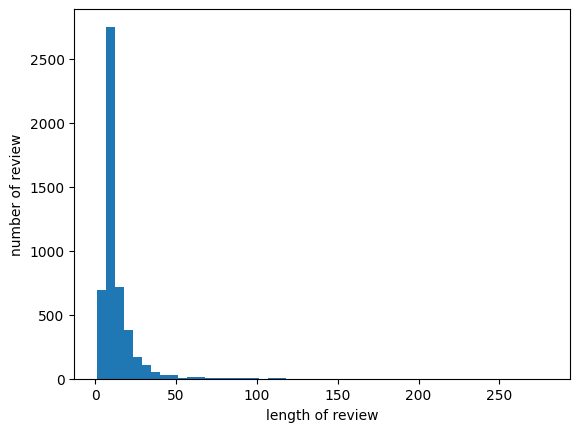

In [ ]:
print('리뷰의 최대 단어 수 :', max(len(review) for review in review_list))
print('리뷰의 평균 단어 수 :', sum(map(len, review_list))/len(review_list))
plt.hist([len(review) for review in review_list], bins=50)
plt.xlabel('length of review')
plt.ylabel('number of review')
plt.show()

In [ ]:
df2["Review"][0]

'무슨 2군데나 터진 불량품을 보내나요? 검수 안하나요? 너무나도 어이없어서 교환 환불 하고싶은데 택배 보낼 시간이 없어서 튀어나온 털만 그냥 가위로 잘라서 씁니다. 뭔가 줄이 쭈굴쭈굴해서 뒤에서 보니 너무 티가 많이나는데 하 살다살다 이런불량 처음. 돈내고 스트레스 받고 할인 하고 인기많아서 대충 만든옷 받아야되나 싶고 열받습니다. 그냥 구매 실패'

In [ ]:
def analyze_review(review):

  try:
    messages = [
            {"role": "system", "content": "너는 패션 옷 리뷰에 담긴 고객 감정을 분석하고 탐지하는 AI 언어모델이야"},
            {"role": "user", "content": f"다음 옷 리뷰를 분석하여 각 고객 별  감정이 긍정인지 부정인지 판단해 알려줘. 대답은 다른 추가적인 설명없이 '긍정' 또는 '부정'  둘 중 하나의 단어로 대답해야 해: {review}"}
        ]

    completion = openai.ChatCompletion.create(
            model="gpt-4",
            messages = messages,
            max_tokens=5,
            n= 1,
            stop=None,
            temperature=0.5
        )

    response= completion.choices[0].message.content
    print(response)
    return response

  except openai.error.RateLimitError as e:
    retry_time = e.retry_after if hasattr(e, 'retry_after') else 30
    print(f"Rate limit exceeded. Retrying in {retry_time} seconds...")
    time.sleep(retry_time)
    return analyze_review(review)

  except openai.error.ServiceUnavailableError as e:
    retry_time = 10  # Adjust the retry time as needed
    print(f"Service is unavailable. Retrying in {retry_time} seconds...")
    time.sleep(retry_time)
    return analyze_review(review)

  except openai.error.APIError as e:
    retry_time = e.retry_after if hasattr(e, 'retry_after') else 30
    print(f"API error occurred. Retrying in {retry_time} seconds...")
    time.sleep(retry_time)
    return analyze_review(review)

# 리뷰 분석해 저장하기
sentiments = []
count = 101
for i in tqdm(range(len(df2["Review"]))):
  count += 1
  sentiment = analyze_review(df2["Review"][i])
  sentiments.append(sentiment)
  df2["Sentiment"] = sentiments
  if count // 100 == 0:
    df2.to_csv('/content/drive/MyDrive/data/label_train'+ str(i) + '.csv', index = False, encoding = 'utf-8-sig')

  0%|          | 1/5000 [00:00<57:01,  1.46it/s]

부정


  0%|          | 2/5000 [00:01<57:28,  1.45it/s]

긍정


  0%|          | 3/5000 [00:02<56:30,  1.47it/s]

긍정


  0%|          | 4/5000 [00:02<58:51,  1.41it/s]

긍정


  0%|          | 5/5000 [00:03<52:35,  1.58it/s]

부정


  0%|          | 6/5000 [00:03<53:28,  1.56it/s]

긍정


  0%|          | 7/5000 [00:04<54:00,  1.54it/s]

긍정


  0%|          | 8/5000 [00:05<1:01:03,  1.36it/s]

긍정


  0%|          | 9/5000 [00:06<1:16:30,  1.09it/s]

부정


  0%|          | 10/5000 [00:08<1:22:50,  1.00it/s]

긍정


  0%|          | 11/5000 [00:08<1:13:11,  1.14it/s]

부정


  0%|          | 12/5000 [00:09<1:12:01,  1.15it/s]

부정


  0%|          | 13/5000 [00:10<1:15:08,  1.11it/s]

긍정


  0%|          | 14/5000 [00:11<1:12:08,  1.15it/s]

부정


  0%|          | 15/5000 [00:12<1:11:43,  1.16it/s]

긍정


  0%|          | 16/5000 [00:12<1:08:49,  1.21it/s]

긍정


  0%|          | 17/5000 [00:13<1:12:05,  1.15it/s]

긍정


  0%|          | 18/5000 [00:14<1:06:38,  1.25it/s]

긍정


  0%|          | 19/5000 [00:15<1:01:07,  1.36it/s]

긍정


  0%|          | 20/5000 [00:16<1:07:09,  1.24it/s]

긍정


  0%|          | 21/5000 [00:17<1:18:49,  1.05it/s]

부정


  0%|          | 22/5000 [00:17<1:11:58,  1.15it/s]

긍정


  0%|          | 23/5000 [00:19<1:18:02,  1.06it/s]

긍정


  0%|          | 24/5000 [00:19<1:10:52,  1.17it/s]

부정


  0%|          | 25/5000 [00:21<1:25:14,  1.03s/it]

부정


  1%|          | 26/5000 [00:21<1:14:16,  1.12it/s]

긍정


  1%|          | 27/5000 [00:22<1:08:27,  1.21it/s]

긍정


  1%|          | 28/5000 [00:23<1:20:31,  1.03it/s]

긍정


  1%|          | 29/5000 [00:24<1:12:25,  1.14it/s]

긍정


  1%|          | 30/5000 [00:25<1:07:07,  1.23it/s]

긍정


  1%|          | 31/5000 [00:25<1:04:42,  1.28it/s]

긍정


  1%|          | 32/5000 [00:26<59:58,  1.38it/s]  

부정


  1%|          | 33/5000 [00:27<59:57,  1.38it/s]

긍정


  1%|          | 34/5000 [00:27<58:27,  1.42it/s]

긍정


  1%|          | 35/5000 [00:29<1:13:12,  1.13it/s]

긍정


  1%|          | 36/5000 [00:29<1:08:16,  1.21it/s]

긍정


  1%|          | 37/5000 [00:30<1:11:39,  1.15it/s]

긍정


  1%|          | 38/5000 [00:31<1:04:52,  1.27it/s]

긍정


  1%|          | 39/5000 [00:31<1:00:51,  1.36it/s]

부정


  1%|          | 40/5000 [00:32<1:00:42,  1.36it/s]

긍정


  1%|          | 41/5000 [00:33<55:25,  1.49it/s]  

긍정


  1%|          | 42/5000 [00:34<1:04:14,  1.29it/s]

긍정


  1%|          | 43/5000 [00:34<1:00:06,  1.37it/s]

긍정


  1%|          | 44/5000 [00:35<54:59,  1.50it/s]  

긍정


  1%|          | 45/5000 [00:35<53:41,  1.54it/s]

긍정


  1%|          | 46/5000 [00:36<55:16,  1.49it/s]

긍정


  1%|          | 47/5000 [00:37<52:53,  1.56it/s]

긍정


  1%|          | 48/5000 [00:38<1:03:26,  1.30it/s]

긍정


  1%|          | 49/5000 [00:39<1:19:28,  1.04it/s]

긍정


  1%|          | 50/5000 [00:40<1:12:39,  1.14it/s]

긍정


  1%|          | 51/5000 [00:42<1:38:42,  1.20s/it]

긍정


  1%|          | 52/5000 [00:42<1:20:36,  1.02it/s]

긍정


  1%|          | 53/5000 [00:43<1:16:27,  1.08it/s]

긍정


  1%|          | 54/5000 [00:45<1:29:09,  1.08s/it]

긍정


  1%|          | 55/5000 [00:45<1:17:19,  1.07it/s]

부정


  1%|          | 56/5000 [00:46<1:10:11,  1.17it/s]

부정


  1%|          | 57/5000 [00:46<1:06:00,  1.25it/s]

긍정


  1%|          | 58/5000 [00:47<59:10,  1.39it/s]  

긍정


  1%|          | 59/5000 [00:48<55:23,  1.49it/s]

긍정


  1%|          | 60/5000 [00:48<53:07,  1.55it/s]

긍정


  1%|          | 61/5000 [00:49<57:51,  1.42it/s]

긍정


  1%|          | 62/5000 [00:50<57:15,  1.44it/s]

긍정


  1%|▏         | 63/5000 [00:50<57:05,  1.44it/s]

긍정


  1%|▏         | 64/5000 [00:51<55:36,  1.48it/s]

긍정


  1%|▏         | 65/5000 [00:52<55:36,  1.48it/s]

긍정


  1%|▏         | 66/5000 [00:53<1:09:48,  1.18it/s]

긍정


  1%|▏         | 67/5000 [00:53<1:02:09,  1.32it/s]

긍정


  1%|▏         | 68/5000 [00:54<59:41,  1.38it/s]  

긍정


  1%|▏         | 69/5000 [00:55<56:55,  1.44it/s]

긍정


  1%|▏         | 70/5000 [00:55<58:29,  1.40it/s]

긍정


  1%|▏         | 71/5000 [00:56<58:32,  1.40it/s]

긍정


  1%|▏         | 72/5000 [00:57<55:31,  1.48it/s]

긍정


  1%|▏         | 73/5000 [00:58<57:43,  1.42it/s]

긍정


  1%|▏         | 74/5000 [00:58<53:19,  1.54it/s]

긍정


  2%|▏         | 75/5000 [00:59<54:17,  1.51it/s]

긍정


  2%|▏         | 76/5000 [01:00<1:06:49,  1.23it/s]

긍정


  2%|▏         | 77/5000 [01:01<1:11:53,  1.14it/s]

긍정


  2%|▏         | 78/5000 [01:02<1:06:03,  1.24it/s]

긍정


  2%|▏         | 79/5000 [01:03<1:09:43,  1.18it/s]

긍정


  2%|▏         | 80/5000 [01:05<1:38:03,  1.20s/it]

긍정


  2%|▏         | 81/5000 [01:05<1:27:15,  1.06s/it]

긍정


  2%|▏         | 82/5000 [01:06<1:18:28,  1.04it/s]

긍정


  2%|▏         | 83/5000 [01:07<1:08:44,  1.19it/s]

긍정


  2%|▏         | 84/5000 [01:07<1:06:50,  1.23it/s]

긍정


  2%|▏         | 85/5000 [01:08<1:07:30,  1.21it/s]

긍정


  2%|▏         | 86/5000 [01:09<1:04:40,  1.27it/s]

긍정


  2%|▏         | 87/5000 [01:10<1:06:16,  1.24it/s]

긍정


  2%|▏         | 88/5000 [01:10<1:00:59,  1.34it/s]

긍정


  2%|▏         | 89/5000 [01:11<57:53,  1.41it/s]  

긍정


  2%|▏         | 90/5000 [01:12<56:38,  1.44it/s]

긍정


  2%|▏         | 91/5000 [01:12<54:42,  1.50it/s]

부정


  2%|▏         | 92/5000 [01:13<49:55,  1.64it/s]

부정


  2%|▏         | 93/5000 [01:14<55:06,  1.48it/s]

긍정


  2%|▏         | 94/5000 [01:14<53:08,  1.54it/s]

긍정


  2%|▏         | 95/5000 [01:15<53:38,  1.52it/s]

긍정


  2%|▏         | 96/5000 [01:16<56:10,  1.46it/s]

부정


  2%|▏         | 97/5000 [01:17<1:02:15,  1.31it/s]

긍정


  2%|▏         | 98/5000 [01:17<58:27,  1.40it/s]  

긍정


  2%|▏         | 99/5000 [01:18<54:38,  1.49it/s]

긍정


  2%|▏         | 100/5000 [01:18<50:58,  1.60it/s]

긍정


  2%|▏         | 101/5000 [01:20<1:14:00,  1.10it/s]

긍정


  2%|▏         | 102/5000 [01:20<1:06:39,  1.22it/s]

긍정


  2%|▏         | 103/5000 [01:21<1:00:38,  1.35it/s]

긍정


  2%|▏         | 104/5000 [01:22<56:52,  1.43it/s]  

긍정


  2%|▏         | 105/5000 [01:22<52:19,  1.56it/s]

긍정


  2%|▏         | 106/5000 [01:23<55:38,  1.47it/s]

긍정


  2%|▏         | 107/5000 [01:23<54:00,  1.51it/s]

긍정


  2%|▏         | 108/5000 [01:24<51:38,  1.58it/s]

긍정


  2%|▏         | 109/5000 [01:25<1:02:42,  1.30it/s]

긍정


  2%|▏         | 110/5000 [01:26<58:58,  1.38it/s]  

긍정


  2%|▏         | 111/5000 [01:27<1:01:58,  1.31it/s]

긍정


  2%|▏         | 112/5000 [01:27<59:58,  1.36it/s]  

긍정


  2%|▏         | 113/5000 [01:28<53:50,  1.51it/s]

긍정


  2%|▏         | 114/5000 [01:29<57:29,  1.42it/s]

긍정


  2%|▏         | 115/5000 [01:29<56:07,  1.45it/s]

긍정


  2%|▏         | 116/5000 [01:30<1:01:33,  1.32it/s]

부정


  2%|▏         | 117/5000 [01:31<59:59,  1.36it/s]  

긍정


  2%|▏         | 118/5000 [01:32<1:10:13,  1.16it/s]

긍정


  2%|▏         | 119/5000 [01:33<1:07:23,  1.21it/s]

부정


  2%|▏         | 120/5000 [01:34<1:22:21,  1.01s/it]

긍정


  2%|▏         | 121/5000 [01:35<1:15:09,  1.08it/s]

긍정


  2%|▏         | 122/5000 [01:35<1:07:15,  1.21it/s]

긍정


  2%|▏         | 123/5000 [01:36<1:03:01,  1.29it/s]

긍정


  2%|▏         | 124/5000 [01:37<58:20,  1.39it/s]  

긍정


  2%|▎         | 125/5000 [01:37<55:06,  1.47it/s]

긍정


  3%|▎         | 126/5000 [01:38<54:03,  1.50it/s]

긍정


  3%|▎         | 127/5000 [01:38<50:52,  1.60it/s]

부정


  3%|▎         | 128/5000 [01:40<1:15:58,  1.07it/s]

긍정


  3%|▎         | 129/5000 [01:41<1:11:25,  1.14it/s]

긍정


  3%|▎         | 130/5000 [01:42<1:06:15,  1.23it/s]

긍정


  3%|▎         | 131/5000 [01:42<1:03:43,  1.27it/s]

긍정


  3%|▎         | 132/5000 [01:43<1:07:25,  1.20it/s]

긍정


  3%|▎         | 133/5000 [01:44<1:02:04,  1.31it/s]

긍정


  3%|▎         | 134/5000 [01:45<1:06:15,  1.22it/s]

긍정


  3%|▎         | 135/5000 [01:45<1:01:24,  1.32it/s]

긍정


  3%|▎         | 136/5000 [01:46<56:53,  1.42it/s]  

긍정


  3%|▎         | 137/5000 [01:47<1:12:35,  1.12it/s]

긍정


  3%|▎         | 138/5000 [01:48<1:06:32,  1.22it/s]

긍정


  3%|▎         | 139/5000 [01:49<1:10:43,  1.15it/s]

긍정


  3%|▎         | 140/5000 [01:50<1:11:42,  1.13it/s]

긍정


  3%|▎         | 141/5000 [01:50<1:03:40,  1.27it/s]

긍정


  3%|▎         | 142/5000 [01:51<1:05:50,  1.23it/s]

긍정


  3%|▎         | 143/5000 [01:52<1:02:45,  1.29it/s]

긍정


  3%|▎         | 144/5000 [01:53<1:13:12,  1.11it/s]

긍정


  3%|▎         | 145/5000 [01:54<1:06:59,  1.21it/s]

긍정


  3%|▎         | 146/5000 [01:54<1:02:55,  1.29it/s]

긍정


  3%|▎         | 147/5000 [01:55<1:08:26,  1.18it/s]

긍정


  3%|▎         | 148/5000 [01:56<1:05:51,  1.23it/s]

긍정


  3%|▎         | 149/5000 [01:57<1:01:15,  1.32it/s]

긍정


  3%|▎         | 150/5000 [01:57<58:21,  1.39it/s]  

긍정


  3%|▎         | 151/5000 [01:58<57:03,  1.42it/s]

긍정


  3%|▎         | 152/5000 [01:59<58:14,  1.39it/s]

긍정


  3%|▎         | 153/5000 [02:00<1:03:39,  1.27it/s]

긍정


  3%|▎         | 154/5000 [02:01<1:01:32,  1.31it/s]

긍정


  3%|▎         | 155/5000 [02:01<56:50,  1.42it/s]  

긍정


  3%|▎         | 156/5000 [02:02<1:01:54,  1.30it/s]

긍정


  3%|▎         | 157/5000 [02:03<56:22,  1.43it/s]  

긍정


  3%|▎         | 158/5000 [02:03<1:01:45,  1.31it/s]

긍정


  3%|▎         | 159/5000 [02:04<59:33,  1.35it/s]  

부정


  3%|▎         | 160/5000 [02:05<54:04,  1.49it/s]

부정


  3%|▎         | 161/5000 [02:06<59:25,  1.36it/s]

긍정


  3%|▎         | 162/5000 [02:07<1:06:47,  1.21it/s]

긍정


  3%|▎         | 163/5000 [02:08<1:12:06,  1.12it/s]

긍정


  3%|▎         | 164/5000 [02:08<1:06:04,  1.22it/s]

긍정


  3%|▎         | 165/5000 [02:09<1:00:57,  1.32it/s]

긍정


  3%|▎         | 166/5000 [02:09<53:46,  1.50it/s]  

긍정


  3%|▎         | 167/5000 [02:10<55:19,  1.46it/s]

긍정


  3%|▎         | 168/5000 [02:11<1:02:54,  1.28it/s]

긍정


  3%|▎         | 169/5000 [02:12<1:03:06,  1.28it/s]

긍정


  3%|▎         | 170/5000 [02:12<58:41,  1.37it/s]  

긍정


  3%|▎         | 171/5000 [02:14<1:08:46,  1.17it/s]

긍정


  3%|▎         | 172/5000 [02:15<1:11:41,  1.12it/s]

긍정


  3%|▎         | 173/5000 [02:15<1:03:50,  1.26it/s]

긍정


  3%|▎         | 174/5000 [02:16<58:58,  1.36it/s]  

긍정


  4%|▎         | 175/5000 [02:17<1:04:14,  1.25it/s]

긍정


  4%|▎         | 176/5000 [02:18<1:05:25,  1.23it/s]

긍정


  4%|▎         | 177/5000 [02:18<59:42,  1.35it/s]  

긍정


  4%|▎         | 178/5000 [02:19<56:15,  1.43it/s]

긍정


  4%|▎         | 179/5000 [02:20<1:20:22,  1.00s/it]

긍정


  4%|▎         | 180/5000 [02:21<1:09:17,  1.16it/s]

긍정


  4%|▎         | 181/5000 [02:22<1:02:13,  1.29it/s]

긍정


  4%|▎         | 182/5000 [02:22<57:58,  1.39it/s]  

긍정


  4%|▎         | 183/5000 [02:23<54:07,  1.48it/s]

긍정


  4%|▎         | 184/5000 [02:23<55:09,  1.46it/s]

긍정


  4%|▎         | 185/5000 [02:24<50:54,  1.58it/s]

긍정


  4%|▎         | 186/5000 [02:25<50:33,  1.59it/s]

긍정


  4%|▎         | 187/5000 [02:25<52:57,  1.51it/s]

긍정


  4%|▍         | 188/5000 [02:27<1:10:36,  1.14it/s]

긍정


  4%|▍         | 189/5000 [02:28<1:09:34,  1.15it/s]

긍정


  4%|▍         | 190/5000 [02:28<1:03:10,  1.27it/s]

긍정


  4%|▍         | 191/5000 [02:29<1:01:55,  1.29it/s]

긍정


  4%|▍         | 192/5000 [02:29<56:45,  1.41it/s]  

긍정


  4%|▍         | 193/5000 [02:30<1:02:38,  1.28it/s]

긍정


  4%|▍         | 194/5000 [02:31<1:00:54,  1.32it/s]

긍정


  4%|▍         | 195/5000 [02:32<57:12,  1.40it/s]  

긍정


  4%|▍         | 196/5000 [02:32<54:32,  1.47it/s]

긍정


  4%|▍         | 197/5000 [02:33<50:29,  1.59it/s]

긍정


  4%|▍         | 198/5000 [02:34<53:09,  1.51it/s]

긍정


  4%|▍         | 199/5000 [02:34<52:00,  1.54it/s]

긍정


  4%|▍         | 200/5000 [02:35<1:00:12,  1.33it/s]

부정


  4%|▍         | 201/5000 [02:36<55:24,  1.44it/s]  

긍정


  4%|▍         | 202/5000 [02:36<53:10,  1.50it/s]

긍정


  4%|▍         | 203/5000 [02:37<58:07,  1.38it/s]

긍정


  4%|▍         | 204/5000 [02:38<54:51,  1.46it/s]

긍정


  4%|▍         | 205/5000 [02:39<1:13:12,  1.09it/s]

긍정


  4%|▍         | 206/5000 [02:40<1:06:12,  1.21it/s]

긍정


  4%|▍         | 207/5000 [02:40<1:01:23,  1.30it/s]

긍정


  4%|▍         | 208/5000 [02:41<1:04:06,  1.25it/s]

긍정


  4%|▍         | 209/5000 [02:42<57:26,  1.39it/s]  

부정


  4%|▍         | 210/5000 [02:43<57:26,  1.39it/s]

긍정


  4%|▍         | 211/5000 [02:43<55:38,  1.43it/s]

긍정


  4%|▍         | 212/5000 [02:44<52:30,  1.52it/s]

긍정


  4%|▍         | 213/5000 [02:44<53:04,  1.50it/s]

긍정


  4%|▍         | 214/5000 [02:45<48:40,  1.64it/s]

긍정


  4%|▍         | 215/5000 [02:46<57:38,  1.38it/s]

긍정


  4%|▍         | 216/5000 [02:47<1:13:14,  1.09it/s]

긍정


  4%|▍         | 217/5000 [02:48<1:18:52,  1.01it/s]

긍정


  4%|▍         | 218/5000 [02:49<1:10:05,  1.14it/s]

긍정


  4%|▍         | 219/5000 [02:50<1:07:35,  1.18it/s]

긍정


  4%|▍         | 220/5000 [02:51<1:02:12,  1.28it/s]

긍정


  4%|▍         | 221/5000 [02:51<1:05:15,  1.22it/s]

긍정


  4%|▍         | 222/5000 [02:52<1:01:03,  1.30it/s]

긍정


  4%|▍         | 223/5000 [02:53<1:03:47,  1.25it/s]

부정


  4%|▍         | 224/5000 [02:54<57:49,  1.38it/s]  

부정


  4%|▍         | 225/5000 [02:54<58:36,  1.36it/s]

긍정


  5%|▍         | 226/5000 [02:55<58:18,  1.36it/s]

긍정


  5%|▍         | 227/5000 [02:56<55:04,  1.44it/s]

긍정


  5%|▍         | 228/5000 [02:56<55:52,  1.42it/s]

긍정


  5%|▍         | 229/5000 [02:57<57:12,  1.39it/s]

긍정


  5%|▍         | 230/5000 [02:58<58:25,  1.36it/s]

긍정


  5%|▍         | 231/5000 [02:59<57:26,  1.38it/s]

긍정


  5%|▍         | 232/5000 [02:59<59:35,  1.33it/s]

긍정


  5%|▍         | 233/5000 [03:00<56:16,  1.41it/s]

긍정


  5%|▍         | 234/5000 [03:01<56:14,  1.41it/s]

긍정


  5%|▍         | 235/5000 [03:01<52:48,  1.50it/s]

긍정


  5%|▍         | 236/5000 [03:02<50:41,  1.57it/s]

긍정


  5%|▍         | 237/5000 [03:03<1:01:25,  1.29it/s]

긍정


  5%|▍         | 238/5000 [03:04<1:03:12,  1.26it/s]

긍정


  5%|▍         | 239/5000 [03:04<59:07,  1.34it/s]  

긍정


  5%|▍         | 240/5000 [03:05<1:00:09,  1.32it/s]

긍정


  5%|▍         | 241/5000 [03:06<56:02,  1.42it/s]  

긍정


  5%|▍         | 242/5000 [03:07<1:01:24,  1.29it/s]

긍정


  5%|▍         | 243/5000 [03:07<55:39,  1.42it/s]  

긍정


  5%|▍         | 244/5000 [03:08<59:34,  1.33it/s]

긍정


  5%|▍         | 245/5000 [03:09<57:23,  1.38it/s]

긍정


  5%|▍         | 246/5000 [03:09<52:54,  1.50it/s]

긍정


  5%|▍         | 247/5000 [03:10<1:04:00,  1.24it/s]

긍정


  5%|▍         | 248/5000 [03:12<1:18:58,  1.00it/s]

긍정


  5%|▍         | 249/5000 [03:12<1:08:05,  1.16it/s]

긍정


  5%|▌         | 250/5000 [03:14<1:17:48,  1.02it/s]

긍정


  5%|▌         | 251/5000 [03:14<1:09:24,  1.14it/s]

긍정


  5%|▌         | 252/5000 [03:15<1:05:08,  1.21it/s]

긍정


  5%|▌         | 253/5000 [03:16<1:06:00,  1.20it/s]

긍정


  5%|▌         | 254/5000 [03:16<1:01:16,  1.29it/s]

긍정


  5%|▌         | 255/5000 [03:17<57:52,  1.37it/s]  

긍정


  5%|▌         | 256/5000 [03:18<56:14,  1.41it/s]

긍정


  5%|▌         | 257/5000 [03:18<51:28,  1.54it/s]

긍정


  5%|▌         | 258/5000 [03:19<53:08,  1.49it/s]

긍정


  5%|▌         | 259/5000 [03:21<1:22:20,  1.04s/it]

긍정


  5%|▌         | 260/5000 [03:22<1:11:59,  1.10it/s]

긍정


  5%|▌         | 261/5000 [03:22<1:05:04,  1.21it/s]

부정


  5%|▌         | 262/5000 [03:23<58:00,  1.36it/s]  

부정


  5%|▌         | 263/5000 [03:24<1:07:23,  1.17it/s]

긍정


  5%|▌         | 264/5000 [03:24<1:01:33,  1.28it/s]

긍정


  5%|▌         | 265/5000 [03:25<56:42,  1.39it/s]  

긍정


  5%|▌         | 266/5000 [03:26<1:04:00,  1.23it/s]

부정


  5%|▌         | 267/5000 [03:27<58:56,  1.34it/s]  

긍정


  5%|▌         | 268/5000 [03:27<57:03,  1.38it/s]

긍정


  5%|▌         | 269/5000 [03:28<59:35,  1.32it/s]

긍정


  5%|▌         | 270/5000 [03:29<1:02:57,  1.25it/s]

긍정


  5%|▌         | 271/5000 [03:30<59:23,  1.33it/s]  

긍정


  5%|▌         | 272/5000 [03:31<1:05:39,  1.20it/s]

긍정


  5%|▌         | 273/5000 [03:31<1:01:45,  1.28it/s]

긍정


  5%|▌         | 274/5000 [03:32<1:03:57,  1.23it/s]

긍정


  6%|▌         | 275/5000 [03:33<59:33,  1.32it/s]  

부정


  6%|▌         | 276/5000 [03:33<53:19,  1.48it/s]

긍정


  6%|▌         | 277/5000 [03:34<54:10,  1.45it/s]

긍정


  6%|▌         | 278/5000 [03:35<57:07,  1.38it/s]

긍정


  6%|▌         | 279/5000 [03:35<53:38,  1.47it/s]

긍정


  6%|▌         | 280/5000 [03:36<56:28,  1.39it/s]

긍정


  6%|▌         | 281/5000 [03:37<54:15,  1.45it/s]

긍정


  6%|▌         | 282/5000 [03:37<51:30,  1.53it/s]

긍정


  6%|▌         | 283/5000 [03:38<50:57,  1.54it/s]

긍정


  6%|▌         | 284/5000 [03:39<50:02,  1.57it/s]

긍정


  6%|▌         | 285/5000 [03:39<49:09,  1.60it/s]

긍정


  6%|▌         | 286/5000 [03:40<49:12,  1.60it/s]

긍정


  6%|▌         | 287/5000 [03:41<55:33,  1.41it/s]

긍정


  6%|▌         | 288/5000 [03:41<54:05,  1.45it/s]

긍정


  6%|▌         | 289/5000 [03:42<50:24,  1.56it/s]

긍정


  6%|▌         | 290/5000 [03:43<51:30,  1.52it/s]

긍정


  6%|▌         | 291/5000 [03:44<1:09:50,  1.12it/s]

긍정


  6%|▌         | 292/5000 [03:45<1:18:07,  1.00it/s]

긍정


  6%|▌         | 293/5000 [03:46<1:10:33,  1.11it/s]

긍정


  6%|▌         | 294/5000 [03:47<1:00:58,  1.29it/s]

긍정


  6%|▌         | 295/5000 [03:47<58:13,  1.35it/s]  

긍정


  6%|▌         | 296/5000 [03:48<58:07,  1.35it/s]

긍정


  6%|▌         | 297/5000 [03:49<56:31,  1.39it/s]

긍정


  6%|▌         | 298/5000 [03:49<55:04,  1.42it/s]

긍정


  6%|▌         | 299/5000 [03:50<52:07,  1.50it/s]

긍정


  6%|▌         | 300/5000 [03:50<50:47,  1.54it/s]

긍정


  6%|▌         | 301/5000 [03:51<51:09,  1.53it/s]

긍정


  6%|▌         | 302/5000 [03:52<48:54,  1.60it/s]

긍정


  6%|▌         | 303/5000 [03:52<47:20,  1.65it/s]

긍정


  6%|▌         | 304/5000 [03:53<47:26,  1.65it/s]

긍정


  6%|▌         | 305/5000 [03:53<48:21,  1.62it/s]

긍정


  6%|▌         | 306/5000 [03:54<46:45,  1.67it/s]

긍정


  6%|▌         | 307/5000 [03:55<46:55,  1.67it/s]

긍정


  6%|▌         | 308/5000 [03:56<53:32,  1.46it/s]

긍정


  6%|▌         | 309/5000 [03:57<1:20:46,  1.03s/it]

긍정


  6%|▌         | 310/5000 [03:58<1:14:35,  1.05it/s]

긍정


  6%|▌         | 311/5000 [03:59<1:03:36,  1.23it/s]

긍정


  6%|▌         | 312/5000 [03:59<55:52,  1.40it/s]  

긍정


  6%|▋         | 313/5000 [04:00<53:44,  1.45it/s]

긍정


  6%|▋         | 314/5000 [04:00<50:46,  1.54it/s]

긍정


  6%|▋         | 315/5000 [04:01<1:01:02,  1.28it/s]

긍정


  6%|▋         | 316/5000 [04:02<56:46,  1.37it/s]  

긍정


  6%|▋         | 317/5000 [04:03<1:01:35,  1.27it/s]

긍정


  6%|▋         | 318/5000 [04:04<58:51,  1.33it/s]  

긍정


  6%|▋         | 319/5000 [04:05<1:14:25,  1.05it/s]

긍정


  6%|▋         | 320/5000 [04:06<1:08:18,  1.14it/s]

긍정


  6%|▋         | 321/5000 [04:06<1:03:18,  1.23it/s]

긍정


  6%|▋         | 322/5000 [04:07<1:01:10,  1.27it/s]

긍정


  6%|▋         | 323/5000 [04:08<59:31,  1.31it/s]  

긍정


  6%|▋         | 324/5000 [04:09<1:00:00,  1.30it/s]

긍정


  6%|▋         | 325/5000 [04:09<55:58,  1.39it/s]  

긍정


  7%|▋         | 326/5000 [04:10<51:52,  1.50it/s]

긍정


  7%|▋         | 327/5000 [04:10<52:09,  1.49it/s]

긍정


  7%|▋         | 328/5000 [04:11<50:58,  1.53it/s]

긍정


  7%|▋         | 329/5000 [04:12<50:53,  1.53it/s]

긍정


  7%|▋         | 330/5000 [04:12<49:20,  1.58it/s]

긍정


  7%|▋         | 331/5000 [04:13<50:58,  1.53it/s]

긍정


  7%|▋         | 332/5000 [04:13<46:36,  1.67it/s]

부정


  7%|▋         | 333/5000 [04:14<47:50,  1.63it/s]

긍정


  7%|▋         | 334/5000 [04:15<50:45,  1.53it/s]

긍정


  7%|▋         | 335/5000 [04:15<47:13,  1.65it/s]

긍정


  7%|▋         | 336/5000 [04:16<48:53,  1.59it/s]

긍정


  7%|▋         | 337/5000 [04:17<48:55,  1.59it/s]

긍정


  7%|▋         | 338/5000 [04:17<50:14,  1.55it/s]

긍정


  7%|▋         | 339/5000 [04:18<1:01:30,  1.26it/s]

긍정


  7%|▋         | 340/5000 [04:19<58:28,  1.33it/s]  

긍정


  7%|▋         | 341/5000 [04:20<54:42,  1.42it/s]

긍정


  7%|▋         | 342/5000 [04:20<51:32,  1.51it/s]

긍정


  7%|▋         | 343/5000 [04:21<47:42,  1.63it/s]

부정


  7%|▋         | 344/5000 [04:21<45:12,  1.72it/s]

긍정


  7%|▋         | 345/5000 [04:22<44:44,  1.73it/s]

긍정


  7%|▋         | 346/5000 [04:23<47:23,  1.64it/s]

긍정


  7%|▋         | 347/5000 [04:24<1:00:51,  1.27it/s]

긍정


  7%|▋         | 348/5000 [04:24<57:51,  1.34it/s]  

긍정


  7%|▋         | 349/5000 [04:25<59:05,  1.31it/s]

긍정


  7%|▋         | 350/5000 [04:26<1:00:19,  1.28it/s]

긍정


  7%|▋         | 351/5000 [04:27<1:01:07,  1.27it/s]

긍정


  7%|▋         | 352/5000 [04:27<55:14,  1.40it/s]  

긍정


  7%|▋         | 353/5000 [04:28<58:03,  1.33it/s]

긍정


  7%|▋         | 354/5000 [04:29<1:00:10,  1.29it/s]

부정


  7%|▋         | 355/5000 [04:30<1:08:16,  1.13it/s]

긍정


  7%|▋         | 356/5000 [04:31<59:57,  1.29it/s]  

긍정


  7%|▋         | 357/5000 [04:31<56:02,  1.38it/s]

긍정


  7%|▋         | 358/5000 [04:32<57:30,  1.35it/s]

긍정


  7%|▋         | 359/5000 [04:33<53:54,  1.43it/s]

긍정


  7%|▋         | 360/5000 [04:33<54:25,  1.42it/s]

긍정


  7%|▋         | 361/5000 [04:34<57:10,  1.35it/s]

긍정


  7%|▋         | 362/5000 [04:35<50:35,  1.53it/s]

긍정


  7%|▋         | 363/5000 [04:35<45:25,  1.70it/s]

부정


  7%|▋         | 364/5000 [04:36<48:23,  1.60it/s]

긍정


  7%|▋         | 365/5000 [04:36<47:01,  1.64it/s]

긍정


  7%|▋         | 366/5000 [04:37<49:39,  1.56it/s]

긍정


  7%|▋         | 367/5000 [04:38<52:46,  1.46it/s]

긍정


  7%|▋         | 368/5000 [04:38<50:17,  1.54it/s]

긍정


  7%|▋         | 369/5000 [04:39<52:40,  1.47it/s]

긍정


  7%|▋         | 370/5000 [04:40<56:37,  1.36it/s]

긍정


  7%|▋         | 371/5000 [04:41<57:12,  1.35it/s]

긍정


  7%|▋         | 372/5000 [04:42<1:04:52,  1.19it/s]

긍정


  7%|▋         | 373/5000 [04:43<1:01:21,  1.26it/s]

긍정


  7%|▋         | 374/5000 [04:43<58:01,  1.33it/s]  

긍정


  8%|▊         | 375/5000 [04:44<59:17,  1.30it/s]

긍정


  8%|▊         | 376/5000 [04:45<56:27,  1.36it/s]

긍정


  8%|▊         | 377/5000 [04:46<1:01:33,  1.25it/s]

긍정


  8%|▊         | 378/5000 [04:46<54:28,  1.41it/s]  

긍정


  8%|▊         | 379/5000 [04:47<52:09,  1.48it/s]

긍정


  8%|▊         | 380/5000 [04:47<48:54,  1.57it/s]

긍정


  8%|▊         | 381/5000 [04:48<45:45,  1.68it/s]

긍정


  8%|▊         | 382/5000 [04:49<50:34,  1.52it/s]

긍정


  8%|▊         | 383/5000 [04:49<51:24,  1.50it/s]

긍정


  8%|▊         | 384/5000 [04:50<52:27,  1.47it/s]

긍정


  8%|▊         | 385/5000 [04:51<48:37,  1.58it/s]

긍정


  8%|▊         | 386/5000 [04:52<1:06:44,  1.15it/s]

긍정


  8%|▊         | 387/5000 [04:52<57:42,  1.33it/s]  

긍정


  8%|▊         | 388/5000 [04:53<1:02:04,  1.24it/s]

긍정


  8%|▊         | 389/5000 [04:54<1:07:36,  1.14it/s]

긍정


  8%|▊         | 390/5000 [04:55<1:02:48,  1.22it/s]

긍정


  8%|▊         | 391/5000 [04:56<1:09:09,  1.11it/s]

긍정


  8%|▊         | 392/5000 [04:57<1:01:21,  1.25it/s]

긍정


  8%|▊         | 393/5000 [04:57<56:15,  1.37it/s]  

부정


  8%|▊         | 394/5000 [04:58<54:16,  1.41it/s]

긍정


  8%|▊         | 395/5000 [04:59<51:52,  1.48it/s]

긍정


  8%|▊         | 396/5000 [04:59<51:33,  1.49it/s]

긍정


  8%|▊         | 397/5000 [05:00<1:02:47,  1.22it/s]

긍정


  8%|▊         | 398/5000 [05:01<1:00:57,  1.26it/s]

긍정


  8%|▊         | 399/5000 [05:02<58:09,  1.32it/s]  

긍정


  8%|▊         | 400/5000 [05:03<1:08:10,  1.12it/s]

긍정


  8%|▊         | 401/5000 [05:03<59:31,  1.29it/s]  

긍정


  8%|▊         | 402/5000 [05:04<53:02,  1.44it/s]

부정


  8%|▊         | 403/5000 [05:05<50:40,  1.51it/s]

긍정


  8%|▊         | 404/5000 [05:05<47:43,  1.61it/s]

긍정


  8%|▊         | 405/5000 [05:07<1:06:33,  1.15it/s]

긍정


  8%|▊         | 406/5000 [05:07<1:03:01,  1.21it/s]

긍정


  8%|▊         | 407/5000 [05:08<57:22,  1.33it/s]  

긍정


  8%|▊         | 408/5000 [05:09<1:15:26,  1.01it/s]

긍정


  8%|▊         | 409/5000 [05:10<1:07:14,  1.14it/s]

긍정


  8%|▊         | 410/5000 [05:11<1:10:43,  1.08it/s]

긍정


  8%|▊         | 411/5000 [05:12<1:13:34,  1.04it/s]

긍정


  8%|▊         | 412/5000 [05:13<1:08:48,  1.11it/s]

긍정


  8%|▊         | 413/5000 [05:14<1:21:02,  1.06s/it]

긍정


  8%|▊         | 414/5000 [05:15<1:15:48,  1.01it/s]

긍정


  8%|▊         | 415/5000 [05:16<1:04:50,  1.18it/s]

부정


  8%|▊         | 416/5000 [05:17<1:07:29,  1.13it/s]

긍정


  8%|▊         | 417/5000 [05:18<1:18:37,  1.03s/it]

긍정


  8%|▊         | 418/5000 [05:19<1:12:57,  1.05it/s]

긍정


  8%|▊         | 419/5000 [05:20<1:08:36,  1.11it/s]

긍정


  8%|▊         | 420/5000 [05:20<1:07:57,  1.12it/s]

긍정


  8%|▊         | 421/5000 [05:22<1:34:13,  1.23s/it]

긍정


  8%|▊         | 422/5000 [05:23<1:23:17,  1.09s/it]

부정


  8%|▊         | 423/5000 [05:24<1:12:58,  1.05it/s]

긍정


  8%|▊         | 424/5000 [05:24<1:02:11,  1.23it/s]

긍정


  8%|▊         | 425/5000 [05:25<57:29,  1.33it/s]  

긍정


  9%|▊         | 426/5000 [05:25<53:25,  1.43it/s]

긍정


  9%|▊         | 427/5000 [05:26<50:13,  1.52it/s]

긍정


  9%|▊         | 428/5000 [05:27<49:19,  1.54it/s]

긍정


  9%|▊         | 429/5000 [05:28<53:44,  1.42it/s]

긍정


  9%|▊         | 430/5000 [05:28<57:57,  1.31it/s]

긍정


  9%|▊         | 431/5000 [05:29<55:17,  1.38it/s]

긍정


  9%|▊         | 432/5000 [05:30<1:05:03,  1.17it/s]

긍정


  9%|▊         | 433/5000 [05:31<58:39,  1.30it/s]  

긍정


  9%|▊         | 434/5000 [05:31<55:11,  1.38it/s]

긍정


  9%|▊         | 435/5000 [05:32<49:13,  1.55it/s]

긍정


  9%|▊         | 436/5000 [05:32<47:13,  1.61it/s]

긍정


  9%|▊         | 437/5000 [05:34<1:00:06,  1.27it/s]

긍정


  9%|▉         | 438/5000 [05:34<58:37,  1.30it/s]  

긍정


  9%|▉         | 439/5000 [05:35<1:04:10,  1.18it/s]

긍정


  9%|▉         | 440/5000 [05:36<1:03:32,  1.20it/s]

긍정


  9%|▉         | 441/5000 [05:37<57:03,  1.33it/s]  

긍정


  9%|▉         | 442/5000 [05:37<52:05,  1.46it/s]

긍정


  9%|▉         | 443/5000 [05:38<48:52,  1.55it/s]

긍정


  9%|▉         | 444/5000 [05:38<45:35,  1.67it/s]

긍정


  9%|▉         | 445/5000 [05:40<1:02:47,  1.21it/s]

긍정


  9%|▉         | 446/5000 [05:40<58:56,  1.29it/s]  

긍정


  9%|▉         | 447/5000 [05:41<55:20,  1.37it/s]

긍정


  9%|▉         | 448/5000 [05:42<1:00:58,  1.24it/s]

긍정


  9%|▉         | 449/5000 [05:43<1:02:10,  1.22it/s]

긍정


  9%|▉         | 450/5000 [05:44<1:04:40,  1.17it/s]

긍정


  9%|▉         | 451/5000 [05:45<1:06:49,  1.13it/s]

긍정


  9%|▉         | 452/5000 [05:45<1:00:05,  1.26it/s]

긍정


  9%|▉         | 453/5000 [05:46<57:39,  1.31it/s]  

긍정


  9%|▉         | 454/5000 [05:47<59:00,  1.28it/s]

긍정


  9%|▉         | 455/5000 [05:47<55:05,  1.38it/s]

긍정


  9%|▉         | 456/5000 [05:48<49:52,  1.52it/s]

부정


  9%|▉         | 457/5000 [05:48<49:40,  1.52it/s]

긍정


  9%|▉         | 458/5000 [05:49<47:31,  1.59it/s]

긍정


  9%|▉         | 459/5000 [05:50<53:03,  1.43it/s]

긍정


  9%|▉         | 460/5000 [05:51<52:57,  1.43it/s]

긍정


  9%|▉         | 461/5000 [05:51<52:18,  1.45it/s]

긍정


  9%|▉         | 462/5000 [05:52<50:04,  1.51it/s]

긍정


  9%|▉         | 463/5000 [05:53<49:14,  1.54it/s]

부정


  9%|▉         | 464/5000 [05:53<46:52,  1.61it/s]

긍정


  9%|▉         | 465/5000 [05:54<46:14,  1.63it/s]

긍정


  9%|▉         | 466/5000 [05:55<57:44,  1.31it/s]

긍정


  9%|▉         | 467/5000 [05:55<55:15,  1.37it/s]

긍정


  9%|▉         | 468/5000 [05:56<53:02,  1.42it/s]

긍정


  9%|▉         | 469/5000 [05:56<46:16,  1.63it/s]

부정


  9%|▉         | 470/5000 [05:57<47:26,  1.59it/s]

긍정


  9%|▉         | 471/5000 [05:58<49:18,  1.53it/s]

긍정


  9%|▉         | 472/5000 [05:59<51:22,  1.47it/s]

긍정


  9%|▉         | 473/5000 [06:00<59:37,  1.27it/s]

긍정


  9%|▉         | 474/5000 [06:00<54:29,  1.38it/s]

긍정


 10%|▉         | 475/5000 [06:02<1:17:04,  1.02s/it]

긍정


 10%|▉         | 476/5000 [06:03<1:13:48,  1.02it/s]

긍정


 10%|▉         | 477/5000 [06:03<1:07:01,  1.12it/s]

긍정


 10%|▉         | 478/5000 [06:04<1:00:40,  1.24it/s]

긍정


 10%|▉         | 479/5000 [06:05<59:53,  1.26it/s]  

긍정


 10%|▉         | 480/5000 [06:05<55:43,  1.35it/s]

긍정


 10%|▉         | 481/5000 [06:06<53:40,  1.40it/s]

긍정


 10%|▉         | 482/5000 [06:07<49:37,  1.52it/s]

긍정


 10%|▉         | 483/5000 [06:07<52:19,  1.44it/s]

긍정


 10%|▉         | 484/5000 [06:08<48:00,  1.57it/s]

긍정


 10%|▉         | 485/5000 [06:09<48:02,  1.57it/s]

긍정


 10%|▉         | 486/5000 [06:09<44:19,  1.70it/s]

긍정


 10%|▉         | 487/5000 [06:10<43:31,  1.73it/s]

긍정


 10%|▉         | 488/5000 [06:10<43:06,  1.74it/s]

긍정


 10%|▉         | 489/5000 [06:11<39:11,  1.92it/s]

부정


 10%|▉         | 490/5000 [06:12<55:00,  1.37it/s]

긍정


 10%|▉         | 491/5000 [06:13<1:00:28,  1.24it/s]

긍정


 10%|▉         | 492/5000 [06:13<58:19,  1.29it/s]  

긍정


 10%|▉         | 493/5000 [06:14<52:42,  1.43it/s]

긍정


 10%|▉         | 494/5000 [06:15<52:19,  1.44it/s]

긍정


 10%|▉         | 495/5000 [06:17<1:19:02,  1.05s/it]

긍정


 10%|▉         | 496/5000 [06:18<1:17:57,  1.04s/it]

부정


 10%|▉         | 497/5000 [06:18<1:08:13,  1.10it/s]

긍정


 10%|▉         | 498/5000 [06:19<1:03:06,  1.19it/s]

긍정


 10%|▉         | 499/5000 [06:19<57:25,  1.31it/s]  

부정


 10%|█         | 500/5000 [06:20<59:00,  1.27it/s]

긍정


 10%|█         | 501/5000 [06:21<1:01:52,  1.21it/s]

긍정


 10%|█         | 502/5000 [06:22<57:49,  1.30it/s]  

긍정


 10%|█         | 503/5000 [06:23<55:26,  1.35it/s]

긍정


 10%|█         | 504/5000 [06:23<50:51,  1.47it/s]

긍정


 10%|█         | 505/5000 [06:24<50:18,  1.49it/s]

긍정


 10%|█         | 506/5000 [06:24<47:12,  1.59it/s]

부정


 10%|█         | 507/5000 [06:26<1:01:31,  1.22it/s]

긍정


 10%|█         | 508/5000 [06:26<57:35,  1.30it/s]  

긍정


 10%|█         | 509/5000 [06:27<56:33,  1.32it/s]

긍정


 10%|█         | 510/5000 [06:28<54:57,  1.36it/s]

긍정


 10%|█         | 511/5000 [06:29<59:43,  1.25it/s]

긍정


 10%|█         | 512/5000 [06:29<55:19,  1.35it/s]

부정


 10%|█         | 513/5000 [06:30<54:27,  1.37it/s]

긍정


 10%|█         | 514/5000 [06:30<51:46,  1.44it/s]

긍정


 10%|█         | 515/5000 [06:31<52:51,  1.41it/s]

긍정


 10%|█         | 516/5000 [06:32<51:20,  1.46it/s]

긍정


 10%|█         | 517/5000 [06:33<52:01,  1.44it/s]

긍정


 10%|█         | 518/5000 [06:34<1:00:14,  1.24it/s]

긍정


 10%|█         | 519/5000 [06:34<1:00:27,  1.24it/s]

긍정


 10%|█         | 520/5000 [06:36<1:10:23,  1.06it/s]

긍정


 10%|█         | 521/5000 [06:37<1:11:59,  1.04it/s]

긍정


 10%|█         | 522/5000 [06:37<1:04:37,  1.15it/s]

긍정


 10%|█         | 523/5000 [06:38<59:14,  1.26it/s]  

긍정


 10%|█         | 524/5000 [06:38<52:43,  1.41it/s]

긍정


 10%|█         | 525/5000 [06:39<49:44,  1.50it/s]

긍정


 11%|█         | 526/5000 [06:40<48:46,  1.53it/s]

긍정


 11%|█         | 527/5000 [06:40<43:45,  1.70it/s]

부정


 11%|█         | 528/5000 [06:41<43:56,  1.70it/s]

긍정


 11%|█         | 529/5000 [06:41<45:39,  1.63it/s]

긍정


 11%|█         | 530/5000 [06:42<45:10,  1.65it/s]

긍정


 11%|█         | 531/5000 [06:43<46:16,  1.61it/s]

긍정


 11%|█         | 532/5000 [06:43<45:51,  1.62it/s]

부정


 11%|█         | 533/5000 [06:44<44:34,  1.67it/s]

긍정


 11%|█         | 534/5000 [06:45<1:03:12,  1.18it/s]

긍정


 11%|█         | 535/5000 [06:46<57:01,  1.31it/s]  

긍정


 11%|█         | 536/5000 [06:46<52:23,  1.42it/s]

부정


 11%|█         | 537/5000 [06:47<56:59,  1.31it/s]

긍정


 11%|█         | 538/5000 [06:48<54:59,  1.35it/s]

긍정


 11%|█         | 539/5000 [06:48<51:10,  1.45it/s]

부정


 11%|█         | 540/5000 [06:50<1:00:44,  1.22it/s]

긍정


 11%|█         | 541/5000 [06:50<54:05,  1.37it/s]  

긍정


 11%|█         | 542/5000 [06:51<54:41,  1.36it/s]

긍정


 11%|█         | 543/5000 [06:52<57:48,  1.29it/s]

긍정


 11%|█         | 544/5000 [06:52<55:45,  1.33it/s]

긍정


 11%|█         | 545/5000 [06:53<52:31,  1.41it/s]

긍정


 11%|█         | 546/5000 [06:54<47:49,  1.55it/s]

긍정


 11%|█         | 547/5000 [06:54<47:31,  1.56it/s]

긍정


 11%|█         | 548/5000 [06:55<43:45,  1.70it/s]

긍정


 11%|█         | 549/5000 [06:55<43:16,  1.71it/s]

긍정


 11%|█         | 550/5000 [06:56<54:47,  1.35it/s]

긍정


 11%|█         | 551/5000 [06:57<58:05,  1.28it/s]

긍정


 11%|█         | 552/5000 [06:58<54:24,  1.36it/s]

긍정


 11%|█         | 553/5000 [06:59<56:13,  1.32it/s]

긍정


 11%|█         | 554/5000 [06:59<52:16,  1.42it/s]

긍정


 11%|█         | 555/5000 [07:00<50:42,  1.46it/s]

긍정


 11%|█         | 556/5000 [07:01<52:01,  1.42it/s]

긍정


 11%|█         | 557/5000 [07:01<56:01,  1.32it/s]

부정


 11%|█         | 558/5000 [07:02<56:51,  1.30it/s]

긍정


 11%|█         | 559/5000 [07:03<53:12,  1.39it/s]

긍정


 11%|█         | 560/5000 [07:03<48:55,  1.51it/s]

긍정


 11%|█         | 561/5000 [07:04<47:41,  1.55it/s]

긍정


 11%|█         | 562/5000 [07:05<46:55,  1.58it/s]

긍정


 11%|█▏        | 563/5000 [07:06<54:39,  1.35it/s]

긍정


 11%|█▏        | 564/5000 [07:06<49:32,  1.49it/s]

부정


 11%|█▏        | 565/5000 [07:07<51:46,  1.43it/s]

긍정


 11%|█▏        | 566/5000 [07:07<48:05,  1.54it/s]

긍정


 11%|█▏        | 567/5000 [07:08<44:45,  1.65it/s]

긍정


 11%|█▏        | 568/5000 [07:08<43:26,  1.70it/s]

긍정


 11%|█▏        | 569/5000 [07:09<47:58,  1.54it/s]

긍정


 11%|█▏        | 570/5000 [07:10<47:18,  1.56it/s]

긍정


 11%|█▏        | 571/5000 [07:11<58:05,  1.27it/s]

긍정


 11%|█▏        | 572/5000 [07:12<1:13:19,  1.01it/s]

긍정


 11%|█▏        | 573/5000 [07:13<1:05:37,  1.12it/s]

긍정


 11%|█▏        | 574/5000 [07:14<1:01:53,  1.19it/s]

긍정


 12%|█▏        | 575/5000 [07:14<56:54,  1.30it/s]  

긍정


 12%|█▏        | 576/5000 [07:15<56:00,  1.32it/s]

긍정


 12%|█▏        | 577/5000 [07:16<56:48,  1.30it/s]

긍정


 12%|█▏        | 578/5000 [07:17<55:44,  1.32it/s]

긍정


 12%|█▏        | 579/5000 [07:18<57:11,  1.29it/s]

긍정


 12%|█▏        | 580/5000 [07:18<54:50,  1.34it/s]

긍정


 12%|█▏        | 581/5000 [07:20<1:15:07,  1.02s/it]

긍정


 12%|█▏        | 582/5000 [07:20<1:06:36,  1.11it/s]

긍정


 12%|█▏        | 583/5000 [07:21<58:37,  1.26it/s]  

긍정


 12%|█▏        | 584/5000 [07:22<55:53,  1.32it/s]

긍정


 12%|█▏        | 585/5000 [07:22<49:33,  1.48it/s]

긍정


 12%|█▏        | 586/5000 [07:23<46:20,  1.59it/s]

긍정


 12%|█▏        | 587/5000 [07:24<50:56,  1.44it/s]

긍정


 12%|█▏        | 588/5000 [07:24<53:54,  1.36it/s]

긍정


 12%|█▏        | 589/5000 [07:25<48:31,  1.51it/s]

부정


 12%|█▏        | 590/5000 [07:26<48:28,  1.52it/s]

긍정


 12%|█▏        | 591/5000 [07:28<1:24:27,  1.15s/it]

긍정


 12%|█▏        | 592/5000 [07:28<1:12:13,  1.02it/s]

긍정


 12%|█▏        | 593/5000 [07:29<1:04:15,  1.14it/s]

긍정


 12%|█▏        | 594/5000 [07:30<58:47,  1.25it/s]  

긍정


 12%|█▏        | 595/5000 [07:30<55:16,  1.33it/s]

긍정


 12%|█▏        | 596/5000 [07:31<48:48,  1.50it/s]

부정


 12%|█▏        | 597/5000 [07:31<46:31,  1.58it/s]

긍정


 12%|█▏        | 598/5000 [07:32<51:55,  1.41it/s]

긍정


 12%|█▏        | 599/5000 [07:33<51:09,  1.43it/s]

긍정


 12%|█▏        | 600/5000 [07:34<51:00,  1.44it/s]

긍정


 12%|█▏        | 601/5000 [07:34<48:08,  1.52it/s]

긍정


 12%|█▏        | 602/5000 [07:35<44:56,  1.63it/s]

부정


 12%|█▏        | 603/5000 [07:35<42:00,  1.74it/s]

긍정


 12%|█▏        | 604/5000 [07:37<1:07:01,  1.09it/s]

긍정


 12%|█▏        | 605/5000 [07:37<1:00:32,  1.21it/s]

부정


 12%|█▏        | 606/5000 [07:38<1:00:23,  1.21it/s]

긍정


 12%|█▏        | 607/5000 [07:39<55:14,  1.33it/s]  

긍정


 12%|█▏        | 608/5000 [07:40<53:06,  1.38it/s]

긍정


 12%|█▏        | 609/5000 [07:40<51:06,  1.43it/s]

긍정


 12%|█▏        | 610/5000 [07:41<54:53,  1.33it/s]

긍정


 12%|█▏        | 611/5000 [07:42<53:10,  1.38it/s]

긍정


 12%|█▏        | 612/5000 [07:42<52:26,  1.39it/s]

긍정


 12%|█▏        | 613/5000 [07:43<49:02,  1.49it/s]

긍정


 12%|█▏        | 614/5000 [07:44<57:33,  1.27it/s]

긍정


 12%|█▏        | 615/5000 [07:45<54:26,  1.34it/s]

긍정


 12%|█▏        | 616/5000 [07:46<1:00:27,  1.21it/s]

긍정


 12%|█▏        | 617/5000 [07:46<55:39,  1.31it/s]  

긍정


 12%|█▏        | 618/5000 [07:47<57:28,  1.27it/s]

긍정


 12%|█▏        | 619/5000 [07:48<53:37,  1.36it/s]

긍정


 12%|█▏        | 620/5000 [07:48<53:13,  1.37it/s]

긍정


 12%|█▏        | 621/5000 [07:50<1:04:48,  1.13it/s]

긍정


 12%|█▏        | 622/5000 [07:51<1:02:24,  1.17it/s]

긍정


 12%|█▏        | 623/5000 [07:51<57:15,  1.27it/s]  

긍정


 12%|█▏        | 624/5000 [07:52<56:41,  1.29it/s]

긍정


 12%|█▎        | 625/5000 [07:53<57:30,  1.27it/s]

긍정


 13%|█▎        | 626/5000 [07:53<51:28,  1.42it/s]

긍정


 13%|█▎        | 627/5000 [07:54<53:10,  1.37it/s]

긍정


 13%|█▎        | 628/5000 [07:55<49:30,  1.47it/s]

긍정


 13%|█▎        | 629/5000 [07:55<53:29,  1.36it/s]

긍정


 13%|█▎        | 630/5000 [07:56<51:14,  1.42it/s]

부정


 13%|█▎        | 631/5000 [07:57<53:06,  1.37it/s]

긍정


 13%|█▎        | 632/5000 [07:58<57:43,  1.26it/s]

긍정


 13%|█▎        | 633/5000 [07:59<59:55,  1.21it/s]

긍정


 13%|█▎        | 634/5000 [07:59<55:14,  1.32it/s]

긍정


 13%|█▎        | 635/5000 [08:01<1:05:44,  1.11it/s]

부정


 13%|█▎        | 636/5000 [08:02<1:07:57,  1.07it/s]

긍정


 13%|█▎        | 637/5000 [08:02<1:00:38,  1.20it/s]

긍정


 13%|█▎        | 638/5000 [08:03<58:40,  1.24it/s]  

긍정


 13%|█▎        | 639/5000 [08:04<1:00:07,  1.21it/s]

긍정


 13%|█▎        | 640/5000 [08:04<54:59,  1.32it/s]  

긍정


 13%|█▎        | 641/5000 [08:05<50:40,  1.43it/s]

부정


 13%|█▎        | 642/5000 [08:06<52:04,  1.39it/s]

부정


 13%|█▎        | 643/5000 [08:06<51:28,  1.41it/s]

긍정


 13%|█▎        | 644/5000 [08:07<46:27,  1.56it/s]

긍정


 13%|█▎        | 645/5000 [08:07<46:38,  1.56it/s]

긍정


 13%|█▎        | 646/5000 [08:08<45:51,  1.58it/s]

긍정


 13%|█▎        | 647/5000 [08:09<58:17,  1.24it/s]

긍정


 13%|█▎        | 648/5000 [08:10<52:13,  1.39it/s]

긍정


 13%|█▎        | 649/5000 [08:11<51:20,  1.41it/s]

긍정


 13%|█▎        | 650/5000 [08:11<47:44,  1.52it/s]

부정


 13%|█▎        | 651/5000 [08:12<44:02,  1.65it/s]

긍정


 13%|█▎        | 652/5000 [08:12<44:41,  1.62it/s]

긍정


 13%|█▎        | 653/5000 [08:13<44:25,  1.63it/s]

긍정


 13%|█▎        | 654/5000 [08:14<49:24,  1.47it/s]

긍정


 13%|█▎        | 655/5000 [08:14<46:44,  1.55it/s]

긍정


 13%|█▎        | 656/5000 [08:15<47:20,  1.53it/s]

긍정


 13%|█▎        | 657/5000 [08:16<48:36,  1.49it/s]

긍정


 13%|█▎        | 658/5000 [08:16<47:27,  1.52it/s]

긍정


 13%|█▎        | 659/5000 [08:17<51:36,  1.40it/s]

긍정


 13%|█▎        | 660/5000 [08:18<49:33,  1.46it/s]

부정


 13%|█▎        | 661/5000 [08:18<52:02,  1.39it/s]

긍정


 13%|█▎        | 662/5000 [08:19<52:49,  1.37it/s]

긍정


 13%|█▎        | 663/5000 [08:38<7:18:03,  6.06s/it]

부정


 13%|█▎        | 664/5000 [08:39<5:23:42,  4.48s/it]

긍정


 13%|█▎        | 665/5000 [08:39<4:00:50,  3.33s/it]

긍정


 13%|█▎        | 666/5000 [08:40<3:09:40,  2.63s/it]

긍정


 13%|█▎        | 667/5000 [08:41<2:30:36,  2.09s/it]

긍정


 13%|█▎        | 668/5000 [08:42<2:07:11,  1.76s/it]

긍정


 13%|█▎        | 669/5000 [08:44<2:10:34,  1.81s/it]

긍정


 13%|█▎        | 670/5000 [08:45<1:45:48,  1.47s/it]

부정


 13%|█▎        | 671/5000 [08:45<1:24:40,  1.17s/it]

긍정


 13%|█▎        | 672/5000 [08:46<1:18:12,  1.08s/it]

긍정


 13%|█▎        | 673/5000 [08:46<1:06:35,  1.08it/s]

부정


 13%|█▎        | 674/5000 [08:47<59:29,  1.21it/s]  

긍정


 14%|█▎        | 675/5000 [08:48<54:41,  1.32it/s]

긍정


 14%|█▎        | 676/5000 [08:48<51:36,  1.40it/s]

긍정


 14%|█▎        | 677/5000 [08:49<49:02,  1.47it/s]

긍정


 14%|█▎        | 678/5000 [08:50<49:56,  1.44it/s]

긍정


 14%|█▎        | 679/5000 [08:50<52:53,  1.36it/s]

긍정


 14%|█▎        | 680/5000 [08:51<50:45,  1.42it/s]

긍정


 14%|█▎        | 681/5000 [08:52<54:17,  1.33it/s]

긍정


 14%|█▎        | 682/5000 [08:53<59:40,  1.21it/s]

긍정


 14%|█▎        | 683/5000 [08:53<53:03,  1.36it/s]

긍정


 14%|█▎        | 684/5000 [08:54<54:43,  1.31it/s]

긍정


 14%|█▎        | 685/5000 [08:55<59:53,  1.20it/s]

긍정


 14%|█▎        | 686/5000 [08:56<54:37,  1.32it/s]

긍정


 14%|█▎        | 687/5000 [08:57<59:17,  1.21it/s]

긍정


 14%|█▍        | 688/5000 [08:58<55:56,  1.28it/s]

부정


 14%|█▍        | 689/5000 [08:58<51:19,  1.40it/s]

긍정


 14%|█▍        | 690/5000 [08:59<49:38,  1.45it/s]

긍정


 14%|█▍        | 691/5000 [09:00<1:00:38,  1.18it/s]

긍정


 14%|█▍        | 692/5000 [09:01<57:04,  1.26it/s]  

긍정


 14%|█▍        | 693/5000 [09:01<53:30,  1.34it/s]

긍정


 14%|█▍        | 694/5000 [09:02<51:11,  1.40it/s]

긍정


 14%|█▍        | 695/5000 [09:03<59:43,  1.20it/s]

긍정


 14%|█▍        | 696/5000 [09:04<1:08:41,  1.04it/s]

긍정


 14%|█▍        | 697/5000 [09:05<1:01:34,  1.16it/s]

긍정


 14%|█▍        | 698/5000 [09:05<54:52,  1.31it/s]  

긍정


 14%|█▍        | 699/5000 [09:06<1:00:53,  1.18it/s]

긍정


 14%|█▍        | 700/5000 [09:07<1:03:56,  1.12it/s]

긍정


 14%|█▍        | 701/5000 [09:08<57:17,  1.25it/s]  

긍정


 14%|█▍        | 702/5000 [09:08<48:43,  1.47it/s]

부정


 14%|█▍        | 703/5000 [09:09<45:14,  1.58it/s]

긍정


 14%|█▍        | 704/5000 [09:10<45:59,  1.56it/s]

긍정


 14%|█▍        | 705/5000 [09:10<47:31,  1.51it/s]

긍정


 14%|█▍        | 706/5000 [09:11<48:08,  1.49it/s]

긍정


 14%|█▍        | 707/5000 [09:12<57:31,  1.24it/s]

긍정


 14%|█▍        | 708/5000 [09:13<1:01:14,  1.17it/s]

긍정


 14%|█▍        | 709/5000 [09:14<59:46,  1.20it/s]  

긍정


 14%|█▍        | 710/5000 [09:14<54:17,  1.32it/s]

긍정


 14%|█▍        | 711/5000 [09:15<47:59,  1.49it/s]

부정


 14%|█▍        | 712/5000 [09:16<45:58,  1.55it/s]

부정


 14%|█▍        | 713/5000 [09:16<46:38,  1.53it/s]

긍정


 14%|█▍        | 714/5000 [09:17<46:14,  1.54it/s]

긍정


 14%|█▍        | 715/5000 [09:18<1:07:12,  1.06it/s]

긍정


 14%|█▍        | 716/5000 [09:19<1:06:29,  1.07it/s]

긍정


 14%|█▍        | 717/5000 [09:20<1:03:04,  1.13it/s]

긍정


 14%|█▍        | 718/5000 [09:22<1:16:51,  1.08s/it]

긍정


 14%|█▍        | 719/5000 [09:22<1:06:55,  1.07it/s]

긍정


 14%|█▍        | 720/5000 [09:23<1:02:42,  1.14it/s]

긍정


 14%|█▍        | 721/5000 [09:24<1:02:46,  1.14it/s]

긍정


 14%|█▍        | 722/5000 [09:25<1:00:23,  1.18it/s]

긍정


 14%|█▍        | 723/5000 [09:27<1:24:26,  1.18s/it]

부정


 14%|█▍        | 724/5000 [09:27<1:10:00,  1.02it/s]

부정


 14%|█▍        | 725/5000 [09:28<1:07:15,  1.06it/s]

긍정


 15%|█▍        | 726/5000 [09:29<1:07:09,  1.06it/s]

긍정


 15%|█▍        | 727/5000 [09:30<1:02:00,  1.15it/s]

긍정


 15%|█▍        | 728/5000 [09:31<1:11:03,  1.00it/s]

긍정


 15%|█▍        | 729/5000 [09:33<1:24:47,  1.19s/it]

긍정


 15%|█▍        | 730/5000 [09:33<1:15:19,  1.06s/it]

긍정


 15%|█▍        | 731/5000 [09:34<1:09:43,  1.02it/s]

긍정


 15%|█▍        | 732/5000 [09:35<1:01:57,  1.15it/s]

부정


 15%|█▍        | 733/5000 [09:35<57:26,  1.24it/s]  

긍정


 15%|█▍        | 734/5000 [09:37<1:11:24,  1.00s/it]

긍정


 15%|█▍        | 735/5000 [09:38<1:04:34,  1.10it/s]

긍정


 15%|█▍        | 736/5000 [09:38<1:01:06,  1.16it/s]

긍정


 15%|█▍        | 737/5000 [09:39<56:45,  1.25it/s]  

긍정


 15%|█▍        | 738/5000 [09:40<1:01:13,  1.16it/s]

긍정


 15%|█▍        | 739/5000 [09:41<1:09:20,  1.02it/s]

긍정


 15%|█▍        | 740/5000 [09:42<1:10:38,  1.00it/s]

긍정


 15%|█▍        | 741/5000 [09:43<1:03:59,  1.11it/s]

긍정


 15%|█▍        | 742/5000 [09:44<1:02:01,  1.14it/s]

긍정


 15%|█▍        | 743/5000 [09:44<57:50,  1.23it/s]  

긍정


 15%|█▍        | 744/5000 [09:45<53:25,  1.33it/s]

긍정


 15%|█▍        | 745/5000 [09:46<49:19,  1.44it/s]

부정


 15%|█▍        | 746/5000 [09:46<53:23,  1.33it/s]

긍정


 15%|█▍        | 747/5000 [09:47<52:39,  1.35it/s]

긍정


 15%|█▍        | 748/5000 [09:48<1:00:25,  1.17it/s]

긍정


 15%|█▍        | 749/5000 [09:49<1:01:20,  1.16it/s]

긍정


 15%|█▌        | 750/5000 [09:50<59:49,  1.18it/s]  

긍정


 15%|█▌        | 751/5000 [09:51<1:01:09,  1.16it/s]

긍정


 15%|█▌        | 752/5000 [09:52<1:00:50,  1.16it/s]

긍정


 15%|█▌        | 753/5000 [09:52<51:11,  1.38it/s]  

부정


 15%|█▌        | 754/5000 [09:53<53:18,  1.33it/s]

긍정


 15%|█▌        | 755/5000 [09:54<56:01,  1.26it/s]

부정


 15%|█▌        | 756/5000 [09:55<54:14,  1.30it/s]

긍정


 15%|█▌        | 757/5000 [09:55<51:29,  1.37it/s]

긍정


 15%|█▌        | 758/5000 [09:56<54:30,  1.30it/s]

긍정


 15%|█▌        | 759/5000 [09:57<51:17,  1.38it/s]

긍정


 15%|█▌        | 760/5000 [09:58<53:11,  1.33it/s]

부정


 15%|█▌        | 761/5000 [09:58<51:54,  1.36it/s]

긍정


 15%|█▌        | 762/5000 [09:59<51:46,  1.36it/s]

부정


 15%|█▌        | 763/5000 [10:00<50:04,  1.41it/s]

긍정


 15%|█▌        | 764/5000 [10:00<48:29,  1.46it/s]

긍정


 15%|█▌        | 765/5000 [10:02<1:16:46,  1.09s/it]

긍정


 15%|█▌        | 766/5000 [10:03<1:15:53,  1.08s/it]

긍정


 15%|█▌        | 767/5000 [10:04<1:07:42,  1.04it/s]

긍정


 15%|█▌        | 768/5000 [10:05<1:00:59,  1.16it/s]

긍정


 15%|█▌        | 769/5000 [10:05<58:59,  1.20it/s]  

부정


 15%|█▌        | 770/5000 [10:06<54:53,  1.28it/s]

긍정


 15%|█▌        | 771/5000 [10:07<56:08,  1.26it/s]

긍정


 15%|█▌        | 772/5000 [10:07<50:16,  1.40it/s]

부정


 15%|█▌        | 773/5000 [10:08<49:58,  1.41it/s]

부정


 15%|█▌        | 774/5000 [10:09<48:48,  1.44it/s]

긍정


 16%|█▌        | 775/5000 [10:10<51:38,  1.36it/s]

긍정


 16%|█▌        | 776/5000 [10:11<56:50,  1.24it/s]

긍정


 16%|█▌        | 777/5000 [10:11<57:45,  1.22it/s]

긍정


 16%|█▌        | 778/5000 [10:12<56:03,  1.26it/s]

긍정


 16%|█▌        | 779/5000 [10:13<52:58,  1.33it/s]

긍정


 16%|█▌        | 780/5000 [10:13<50:31,  1.39it/s]

긍정


 16%|█▌        | 781/5000 [10:14<54:10,  1.30it/s]

긍정


 16%|█▌        | 782/5000 [10:15<48:47,  1.44it/s]

긍정


 16%|█▌        | 783/5000 [10:16<59:44,  1.18it/s]

긍정


 16%|█▌        | 784/5000 [10:17<57:57,  1.21it/s]

긍정


 16%|█▌        | 785/5000 [10:17<49:46,  1.41it/s]

부정


 16%|█▌        | 786/5000 [10:18<45:27,  1.55it/s]

부정


 16%|█▌        | 787/5000 [10:18<44:35,  1.57it/s]

긍정


 16%|█▌        | 788/5000 [10:19<42:27,  1.65it/s]

긍정


 16%|█▌        | 789/5000 [10:19<40:50,  1.72it/s]

긍정


 16%|█▌        | 790/5000 [10:20<40:52,  1.72it/s]

긍정


 16%|█▌        | 791/5000 [10:21<39:48,  1.76it/s]

긍정


 16%|█▌        | 792/5000 [10:21<40:08,  1.75it/s]

긍정


 16%|█▌        | 793/5000 [10:22<42:37,  1.65it/s]

긍정


 16%|█▌        | 794/5000 [10:22<42:33,  1.65it/s]

긍정


 16%|█▌        | 795/5000 [10:23<43:47,  1.60it/s]

긍정


 16%|█▌        | 796/5000 [10:24<42:34,  1.65it/s]

긍정


 16%|█▌        | 797/5000 [10:25<55:03,  1.27it/s]

긍정


 16%|█▌        | 798/5000 [10:26<1:04:28,  1.09it/s]

긍정


 16%|█▌        | 799/5000 [10:27<1:00:34,  1.16it/s]

부정


 16%|█▌        | 800/5000 [10:28<1:04:16,  1.09it/s]

긍정


 16%|█▌        | 801/5000 [10:29<1:16:37,  1.09s/it]

긍정


 16%|█▌        | 802/5000 [10:30<1:03:47,  1.10it/s]

긍정


 16%|█▌        | 803/5000 [10:31<57:32,  1.22it/s]  

긍정


 16%|█▌        | 804/5000 [10:32<1:08:23,  1.02it/s]

긍정


 16%|█▌        | 805/5000 [10:32<1:00:27,  1.16it/s]

긍정


 16%|█▌        | 806/5000 [10:33<1:03:12,  1.11it/s]

긍정


 16%|█▌        | 807/5000 [10:34<58:09,  1.20it/s]  

긍정


 16%|█▌        | 808/5000 [10:35<58:21,  1.20it/s]

긍정


 16%|█▌        | 809/5000 [10:36<53:56,  1.29it/s]

긍정


 16%|█▌        | 810/5000 [10:36<50:18,  1.39it/s]

긍정


 16%|█▌        | 811/5000 [10:37<53:06,  1.31it/s]

긍정


 16%|█▌        | 812/5000 [10:38<58:51,  1.19it/s]

긍정


 16%|█▋        | 813/5000 [10:39<58:22,  1.20it/s]

긍정


 16%|█▋        | 814/5000 [10:39<53:37,  1.30it/s]

긍정


 16%|█▋        | 815/5000 [10:40<49:51,  1.40it/s]

긍정


 16%|█▋        | 816/5000 [10:41<49:21,  1.41it/s]

긍정


 16%|█▋        | 817/5000 [10:41<48:58,  1.42it/s]

긍정


 16%|█▋        | 818/5000 [10:42<47:49,  1.46it/s]

긍정


 16%|█▋        | 819/5000 [10:43<51:07,  1.36it/s]

긍정


 16%|█▋        | 820/5000 [10:44<48:07,  1.45it/s]

긍정


 16%|█▋        | 821/5000 [10:44<44:34,  1.56it/s]

긍정


 16%|█▋        | 822/5000 [10:45<57:45,  1.21it/s]

긍정


 16%|█▋        | 823/5000 [10:46<54:55,  1.27it/s]

긍정


 16%|█▋        | 824/5000 [10:47<59:45,  1.16it/s]

긍정


 16%|█▋        | 825/5000 [10:48<1:00:00,  1.16it/s]

긍정


 17%|█▋        | 826/5000 [10:49<54:20,  1.28it/s]  

긍정


 17%|█▋        | 827/5000 [10:49<49:11,  1.41it/s]

긍정


 17%|█▋        | 828/5000 [10:50<49:01,  1.42it/s]

긍정


 17%|█▋        | 829/5000 [10:50<46:37,  1.49it/s]

긍정


 17%|█▋        | 830/5000 [10:51<51:33,  1.35it/s]

긍정


 17%|█▋        | 831/5000 [10:52<45:00,  1.54it/s]

긍정


 17%|█▋        | 832/5000 [10:52<41:42,  1.67it/s]

긍정


 17%|█▋        | 833/5000 [10:53<39:07,  1.78it/s]

부정


 17%|█▋        | 834/5000 [10:53<40:17,  1.72it/s]

부정


 17%|█▋        | 835/5000 [10:54<41:02,  1.69it/s]

긍정


 17%|█▋        | 836/5000 [10:55<1:01:49,  1.12it/s]

긍정


 17%|█▋        | 837/5000 [10:56<56:22,  1.23it/s]  

긍정


 17%|█▋        | 838/5000 [10:57<51:51,  1.34it/s]

긍정


 17%|█▋        | 839/5000 [10:57<49:05,  1.41it/s]

긍정


 17%|█▋        | 840/5000 [10:58<55:56,  1.24it/s]

긍정


 17%|█▋        | 841/5000 [10:59<52:23,  1.32it/s]

긍정


 17%|█▋        | 842/5000 [11:00<50:35,  1.37it/s]

긍정


 17%|█▋        | 843/5000 [11:00<51:22,  1.35it/s]

긍정


 17%|█▋        | 844/5000 [11:01<51:03,  1.36it/s]

긍정


 17%|█▋        | 845/5000 [11:02<49:20,  1.40it/s]

긍정


 17%|█▋        | 846/5000 [11:03<54:53,  1.26it/s]

긍정


 17%|█▋        | 847/5000 [11:03<50:27,  1.37it/s]

긍정


 17%|█▋        | 848/5000 [11:04<56:00,  1.24it/s]

긍정


 17%|█▋        | 849/5000 [11:05<1:01:44,  1.12it/s]

긍정


 17%|█▋        | 850/5000 [11:06<58:12,  1.19it/s]  

긍정


 17%|█▋        | 851/5000 [11:07<58:28,  1.18it/s]

긍정


 17%|█▋        | 852/5000 [11:08<54:55,  1.26it/s]

긍정


 17%|█▋        | 853/5000 [11:08<53:59,  1.28it/s]

긍정


 17%|█▋        | 854/5000 [11:09<49:57,  1.38it/s]

긍정


 17%|█▋        | 855/5000 [11:10<53:51,  1.28it/s]

긍정


 17%|█▋        | 856/5000 [11:11<49:16,  1.40it/s]

긍정


 17%|█▋        | 857/5000 [11:11<46:05,  1.50it/s]

긍정


 17%|█▋        | 858/5000 [11:12<45:26,  1.52it/s]

긍정


 17%|█▋        | 859/5000 [11:12<44:40,  1.54it/s]

긍정


 17%|█▋        | 860/5000 [11:14<57:06,  1.21it/s]

긍정


 17%|█▋        | 861/5000 [11:14<53:47,  1.28it/s]

부정


 17%|█▋        | 862/5000 [11:15<50:23,  1.37it/s]

긍정


 17%|█▋        | 863/5000 [11:16<48:37,  1.42it/s]

긍정


 17%|█▋        | 864/5000 [11:17<55:33,  1.24it/s]

긍정


 17%|█▋        | 865/5000 [11:17<56:19,  1.22it/s]

긍정


 17%|█▋        | 866/5000 [11:19<1:02:15,  1.11it/s]

긍정


 17%|█▋        | 867/5000 [11:19<55:55,  1.23it/s]  

긍정


 17%|█▋        | 868/5000 [11:20<53:40,  1.28it/s]

긍정


 17%|█▋        | 869/5000 [11:20<50:09,  1.37it/s]

긍정


 17%|█▋        | 870/5000 [11:21<45:32,  1.51it/s]

긍정


 17%|█▋        | 871/5000 [11:22<45:04,  1.53it/s]

긍정


 17%|█▋        | 872/5000 [11:22<43:52,  1.57it/s]

긍정


 17%|█▋        | 873/5000 [11:23<44:48,  1.53it/s]

부정


 17%|█▋        | 874/5000 [11:23<43:57,  1.56it/s]

긍정


 18%|█▊        | 875/5000 [11:25<57:12,  1.20it/s]

긍정


 18%|█▊        | 876/5000 [11:25<53:06,  1.29it/s]

긍정


 18%|█▊        | 877/5000 [11:26<58:17,  1.18it/s]

긍정


 18%|█▊        | 878/5000 [11:27<52:00,  1.32it/s]

긍정


 18%|█▊        | 879/5000 [11:28<51:02,  1.35it/s]

긍정


 18%|█▊        | 880/5000 [11:28<48:38,  1.41it/s]

긍정


 18%|█▊        | 881/5000 [11:29<48:17,  1.42it/s]

긍정


 18%|█▊        | 882/5000 [11:29<44:31,  1.54it/s]

긍정


 18%|█▊        | 883/5000 [11:30<51:38,  1.33it/s]

긍정


 18%|█▊        | 884/5000 [11:31<50:47,  1.35it/s]

긍정


 18%|█▊        | 885/5000 [11:32<54:56,  1.25it/s]

긍정


 18%|█▊        | 886/5000 [11:33<1:01:22,  1.12it/s]

긍정


 18%|█▊        | 887/5000 [11:34<56:02,  1.22it/s]  

긍정


 18%|█▊        | 888/5000 [11:34<49:29,  1.38it/s]

긍정


 18%|█▊        | 889/5000 [11:35<51:23,  1.33it/s]

긍정


 18%|█▊        | 890/5000 [11:36<50:50,  1.35it/s]

긍정


 18%|█▊        | 891/5000 [11:37<47:52,  1.43it/s]

긍정


 18%|█▊        | 892/5000 [11:37<52:21,  1.31it/s]

긍정


 18%|█▊        | 893/5000 [11:38<49:38,  1.38it/s]

부정


 18%|█▊        | 894/5000 [11:39<55:22,  1.24it/s]

긍정


 18%|█▊        | 895/5000 [11:40<57:53,  1.18it/s]

긍정


 18%|█▊        | 896/5000 [11:41<56:26,  1.21it/s]

긍정


 18%|█▊        | 897/5000 [11:42<54:28,  1.26it/s]

긍정


 18%|█▊        | 898/5000 [11:42<51:07,  1.34it/s]

긍정


 18%|█▊        | 899/5000 [11:43<54:55,  1.24it/s]

긍정


 18%|█▊        | 900/5000 [11:44<52:06,  1.31it/s]

긍정


 18%|█▊        | 901/5000 [11:44<50:37,  1.35it/s]

긍정


 18%|█▊        | 902/5000 [11:45<46:41,  1.46it/s]

긍정


 18%|█▊        | 903/5000 [11:46<47:42,  1.43it/s]

긍정


 18%|█▊        | 904/5000 [11:46<46:28,  1.47it/s]

긍정


 18%|█▊        | 905/5000 [11:47<43:46,  1.56it/s]

긍정


 18%|█▊        | 906/5000 [11:47<40:49,  1.67it/s]

긍정


 18%|█▊        | 907/5000 [11:48<39:07,  1.74it/s]

긍정


 18%|█▊        | 908/5000 [11:49<41:20,  1.65it/s]

긍정


 18%|█▊        | 909/5000 [11:50<59:43,  1.14it/s]

긍정


 18%|█▊        | 910/5000 [11:51<52:09,  1.31it/s]

긍정


 18%|█▊        | 911/5000 [11:51<47:52,  1.42it/s]

부정


 18%|█▊        | 912/5000 [11:52<48:05,  1.42it/s]

긍정


 18%|█▊        | 913/5000 [11:52<44:46,  1.52it/s]

긍정


 18%|█▊        | 914/5000 [11:53<43:28,  1.57it/s]

긍정


 18%|█▊        | 915/5000 [11:54<42:30,  1.60it/s]

긍정


 18%|█▊        | 916/5000 [11:54<43:25,  1.57it/s]

긍정


 18%|█▊        | 917/5000 [11:55<43:03,  1.58it/s]

긍정


 18%|█▊        | 918/5000 [11:55<41:08,  1.65it/s]

긍정


 18%|█▊        | 919/5000 [11:57<53:09,  1.28it/s]

긍정


 18%|█▊        | 920/5000 [11:57<45:55,  1.48it/s]

부정


 18%|█▊        | 921/5000 [11:58<47:10,  1.44it/s]

긍정


 18%|█▊        | 922/5000 [11:58<46:22,  1.47it/s]

긍정


 18%|█▊        | 923/5000 [11:59<43:31,  1.56it/s]

부정


 18%|█▊        | 924/5000 [12:00<57:24,  1.18it/s]

긍정


 18%|█▊        | 925/5000 [12:02<1:05:01,  1.04it/s]

부정


 19%|█▊        | 926/5000 [12:03<1:09:43,  1.03s/it]

긍정


 19%|█▊        | 927/5000 [12:05<1:41:27,  1.49s/it]

긍정


 19%|█▊        | 928/5000 [12:06<1:25:42,  1.26s/it]

긍정


 19%|█▊        | 929/5000 [12:07<1:10:40,  1.04s/it]

긍정


 19%|█▊        | 930/5000 [12:07<59:25,  1.14it/s]  

긍정


 19%|█▊        | 931/5000 [12:08<55:14,  1.23it/s]

긍정


 19%|█▊        | 932/5000 [12:08<49:29,  1.37it/s]

긍정


 19%|█▊        | 933/5000 [12:09<54:09,  1.25it/s]

긍정


 19%|█▊        | 934/5000 [12:10<50:40,  1.34it/s]

긍정


 19%|█▊        | 935/5000 [12:11<1:05:15,  1.04it/s]

부정


 19%|█▊        | 936/5000 [12:12<57:38,  1.18it/s]  

긍정


 19%|█▊        | 937/5000 [12:13<1:01:45,  1.10it/s]

긍정


 19%|█▉        | 938/5000 [12:14<1:05:55,  1.03it/s]

긍정


 19%|█▉        | 939/5000 [12:15<57:16,  1.18it/s]  

긍정


 19%|█▉        | 940/5000 [12:16<59:29,  1.14it/s]

긍정


 19%|█▉        | 941/5000 [12:16<53:38,  1.26it/s]

긍정


 19%|█▉        | 942/5000 [12:17<56:10,  1.20it/s]

긍정


 19%|█▉        | 943/5000 [12:18<48:45,  1.39it/s]

긍정


 19%|█▉        | 944/5000 [12:18<46:38,  1.45it/s]

긍정


 19%|█▉        | 945/5000 [12:19<50:11,  1.35it/s]

긍정


 19%|█▉        | 946/5000 [12:20<46:57,  1.44it/s]

긍정


 19%|█▉        | 947/5000 [12:20<47:38,  1.42it/s]

긍정


 19%|█▉        | 948/5000 [12:21<47:31,  1.42it/s]

긍정


 19%|█▉        | 949/5000 [12:22<45:08,  1.50it/s]

긍정


 19%|█▉        | 950/5000 [12:22<44:06,  1.53it/s]

긍정


 19%|█▉        | 951/5000 [12:23<42:24,  1.59it/s]

긍정


 19%|█▉        | 952/5000 [12:24<43:50,  1.54it/s]

긍정


 19%|█▉        | 953/5000 [12:24<46:14,  1.46it/s]

긍정


 19%|█▉        | 954/5000 [12:25<46:06,  1.46it/s]

긍정


 19%|█▉        | 955/5000 [12:26<50:19,  1.34it/s]

긍정


 19%|█▉        | 956/5000 [12:26<46:24,  1.45it/s]

긍정


 19%|█▉        | 957/5000 [12:28<57:24,  1.17it/s]

긍정


 19%|█▉        | 958/5000 [12:28<53:07,  1.27it/s]

긍정


 19%|█▉        | 959/5000 [12:29<56:17,  1.20it/s]

긍정


 19%|█▉        | 960/5000 [12:30<54:51,  1.23it/s]

긍정


 19%|█▉        | 961/5000 [12:31<1:00:05,  1.12it/s]

긍정


 19%|█▉        | 962/5000 [12:32<59:19,  1.13it/s]  

긍정


 19%|█▉        | 963/5000 [12:33<53:01,  1.27it/s]

긍정


 19%|█▉        | 964/5000 [12:33<48:24,  1.39it/s]

긍정


 19%|█▉        | 965/5000 [12:34<48:29,  1.39it/s]

긍정


 19%|█▉        | 966/5000 [12:35<51:57,  1.29it/s]

긍정


 19%|█▉        | 967/5000 [12:35<46:30,  1.45it/s]

긍정


 19%|█▉        | 968/5000 [12:36<44:20,  1.52it/s]

긍정


 19%|█▉        | 969/5000 [12:37<49:14,  1.36it/s]

긍정


 19%|█▉        | 970/5000 [12:37<47:22,  1.42it/s]

부정


 19%|█▉        | 971/5000 [12:38<45:15,  1.48it/s]

부정


 19%|█▉        | 972/5000 [12:39<46:16,  1.45it/s]

긍정


 19%|█▉        | 973/5000 [12:39<49:05,  1.37it/s]

긍정


 19%|█▉        | 974/5000 [12:40<47:51,  1.40it/s]

긍정


 20%|█▉        | 975/5000 [12:41<52:37,  1.27it/s]

긍정


 20%|█▉        | 976/5000 [12:42<52:38,  1.27it/s]

긍정


 20%|█▉        | 977/5000 [12:43<1:00:17,  1.11it/s]

부정


 20%|█▉        | 978/5000 [12:44<58:32,  1.14it/s]  

긍정


 20%|█▉        | 979/5000 [12:44<53:33,  1.25it/s]

긍정


 20%|█▉        | 980/5000 [12:45<52:20,  1.28it/s]

긍정


 20%|█▉        | 981/5000 [12:46<51:34,  1.30it/s]

긍정


 20%|█▉        | 982/5000 [12:47<50:26,  1.33it/s]

긍정


 20%|█▉        | 983/5000 [12:47<49:42,  1.35it/s]

부정


 20%|█▉        | 984/5000 [12:48<44:24,  1.51it/s]

긍정


 20%|█▉        | 985/5000 [12:49<52:10,  1.28it/s]

긍정


 20%|█▉        | 986/5000 [12:50<51:15,  1.31it/s]

부정


 20%|█▉        | 987/5000 [12:51<56:15,  1.19it/s]

긍정


 20%|█▉        | 988/5000 [12:51<49:24,  1.35it/s]

긍정


 20%|█▉        | 989/5000 [12:53<1:03:38,  1.05it/s]

긍정


 20%|█▉        | 990/5000 [12:53<59:47,  1.12it/s]  

긍정


 20%|█▉        | 991/5000 [12:54<56:28,  1.18it/s]

긍정


 20%|█▉        | 992/5000 [12:55<54:52,  1.22it/s]

긍정


 20%|█▉        | 993/5000 [12:56<53:12,  1.25it/s]

긍정


 20%|█▉        | 994/5000 [12:56<48:34,  1.37it/s]

긍정


 20%|█▉        | 995/5000 [12:57<49:54,  1.34it/s]

긍정


 20%|█▉        | 996/5000 [12:58<46:55,  1.42it/s]

긍정


 20%|█▉        | 997/5000 [12:58<47:11,  1.41it/s]

긍정


 20%|█▉        | 998/5000 [12:59<42:50,  1.56it/s]

부정


 20%|█▉        | 999/5000 [13:00<49:24,  1.35it/s]

긍정


 20%|██        | 1000/5000 [13:00<46:07,  1.45it/s]

긍정


 20%|██        | 1001/5000 [13:01<41:28,  1.61it/s]

부정


 20%|██        | 1002/5000 [13:01<38:44,  1.72it/s]

긍정


 20%|██        | 1003/5000 [13:02<43:01,  1.55it/s]

긍정


 20%|██        | 1004/5000 [13:03<44:46,  1.49it/s]

긍정


 20%|██        | 1005/5000 [13:04<47:01,  1.42it/s]

부정


 20%|██        | 1006/5000 [13:04<46:01,  1.45it/s]

긍정


 20%|██        | 1007/5000 [13:05<45:47,  1.45it/s]

부정


 20%|██        | 1008/5000 [13:06<48:54,  1.36it/s]

긍정


 20%|██        | 1009/5000 [13:06<45:06,  1.47it/s]

긍정


 20%|██        | 1010/5000 [13:07<47:10,  1.41it/s]

긍정


 20%|██        | 1011/5000 [13:08<46:33,  1.43it/s]

긍정


 20%|██        | 1012/5000 [13:09<49:44,  1.34it/s]

긍정


 20%|██        | 1013/5000 [13:10<51:58,  1.28it/s]

긍정


 20%|██        | 1014/5000 [13:10<48:02,  1.38it/s]

긍정


 20%|██        | 1015/5000 [13:11<50:23,  1.32it/s]

긍정


 20%|██        | 1016/5000 [13:12<50:29,  1.31it/s]

부정


 20%|██        | 1017/5000 [13:12<48:12,  1.38it/s]

긍정


 20%|██        | 1018/5000 [13:13<44:39,  1.49it/s]

긍정


 20%|██        | 1019/5000 [13:14<46:19,  1.43it/s]

긍정


 20%|██        | 1020/5000 [13:14<46:12,  1.44it/s]

긍정


 20%|██        | 1021/5000 [13:15<45:57,  1.44it/s]

긍정


 20%|██        | 1022/5000 [13:16<41:49,  1.59it/s]

긍정


 20%|██        | 1023/5000 [13:16<46:41,  1.42it/s]

긍정


 20%|██        | 1024/5000 [13:18<55:53,  1.19it/s]

긍정


 20%|██        | 1025/5000 [13:19<58:50,  1.13it/s]

긍정


 21%|██        | 1026/5000 [13:20<1:02:38,  1.06it/s]

긍정


 21%|██        | 1027/5000 [13:20<54:56,  1.21it/s]  

긍정


 21%|██        | 1028/5000 [13:21<50:52,  1.30it/s]

긍정


 21%|██        | 1029/5000 [13:21<45:21,  1.46it/s]

긍정


 21%|██        | 1030/5000 [13:22<44:57,  1.47it/s]

긍정


 21%|██        | 1031/5000 [13:23<45:47,  1.44it/s]

긍정


 21%|██        | 1032/5000 [13:23<45:49,  1.44it/s]

부정


 21%|██        | 1033/5000 [13:24<44:28,  1.49it/s]

부정


 21%|██        | 1034/5000 [13:25<45:09,  1.46it/s]

긍정


 21%|██        | 1035/5000 [13:25<42:14,  1.56it/s]

긍정


 21%|██        | 1036/5000 [13:26<41:53,  1.58it/s]

긍정


 21%|██        | 1037/5000 [13:27<45:59,  1.44it/s]

긍정


 21%|██        | 1038/5000 [13:27<43:17,  1.53it/s]

긍정


 21%|██        | 1039/5000 [13:28<43:48,  1.51it/s]

긍정


 21%|██        | 1040/5000 [13:29<41:07,  1.61it/s]

긍정


 21%|██        | 1041/5000 [13:29<40:44,  1.62it/s]

긍정


 21%|██        | 1042/5000 [13:30<53:58,  1.22it/s]

긍정


 21%|██        | 1043/5000 [13:31<48:27,  1.36it/s]

긍정


 21%|██        | 1044/5000 [13:32<50:50,  1.30it/s]

긍정


 21%|██        | 1045/5000 [13:32<48:47,  1.35it/s]

부정


 21%|██        | 1046/5000 [13:33<48:30,  1.36it/s]

긍정


 21%|██        | 1047/5000 [13:34<49:18,  1.34it/s]

긍정


 21%|██        | 1048/5000 [13:35<48:01,  1.37it/s]

긍정


 21%|██        | 1049/5000 [13:35<47:07,  1.40it/s]

긍정


 21%|██        | 1050/5000 [13:36<46:14,  1.42it/s]

긍정


 21%|██        | 1051/5000 [13:37<43:57,  1.50it/s]

긍정


 21%|██        | 1052/5000 [13:37<46:40,  1.41it/s]

긍정


 21%|██        | 1053/5000 [13:38<44:56,  1.46it/s]

긍정


 21%|██        | 1054/5000 [13:39<44:02,  1.49it/s]

부정


 21%|██        | 1055/5000 [13:40<50:39,  1.30it/s]

긍정


 21%|██        | 1056/5000 [13:40<50:57,  1.29it/s]

긍정


 21%|██        | 1057/5000 [13:42<58:59,  1.11it/s]

긍정


 21%|██        | 1058/5000 [13:42<55:50,  1.18it/s]

긍정


 21%|██        | 1059/5000 [13:43<53:55,  1.22it/s]

긍정


 21%|██        | 1060/5000 [13:44<49:57,  1.31it/s]

부정


 21%|██        | 1061/5000 [13:44<44:17,  1.48it/s]

부정


 21%|██        | 1062/5000 [13:45<45:22,  1.45it/s]

긍정


 21%|██▏       | 1063/5000 [13:46<42:38,  1.54it/s]

긍정


 21%|██▏       | 1064/5000 [13:46<40:22,  1.62it/s]

긍정


 21%|██▏       | 1065/5000 [13:47<46:46,  1.40it/s]

긍정


 21%|██▏       | 1066/5000 [13:48<46:01,  1.42it/s]

긍정


 21%|██▏       | 1067/5000 [13:49<53:54,  1.22it/s]

부정


 21%|██▏       | 1068/5000 [13:49<48:49,  1.34it/s]

긍정


 21%|██▏       | 1069/5000 [13:50<43:15,  1.51it/s]

긍정


 21%|██▏       | 1070/5000 [13:51<53:47,  1.22it/s]

부정


 21%|██▏       | 1071/5000 [13:52<49:27,  1.32it/s]

긍정


 21%|██▏       | 1072/5000 [13:52<46:11,  1.42it/s]

긍정


 21%|██▏       | 1073/5000 [13:53<46:26,  1.41it/s]

긍정


 21%|██▏       | 1074/5000 [13:54<44:50,  1.46it/s]

긍정


 22%|██▏       | 1075/5000 [13:54<44:40,  1.46it/s]

긍정


 22%|██▏       | 1076/5000 [13:55<41:33,  1.57it/s]

긍정


 22%|██▏       | 1077/5000 [13:55<39:21,  1.66it/s]

긍정


 22%|██▏       | 1078/5000 [13:56<39:56,  1.64it/s]

긍정


 22%|██▏       | 1079/5000 [13:57<50:14,  1.30it/s]

긍정


 22%|██▏       | 1080/5000 [13:58<52:20,  1.25it/s]

긍정


 22%|██▏       | 1081/5000 [13:59<50:35,  1.29it/s]

긍정


 22%|██▏       | 1082/5000 [14:00<53:10,  1.23it/s]

긍정


 22%|██▏       | 1083/5000 [14:00<50:16,  1.30it/s]

긍정


 22%|██▏       | 1084/5000 [14:01<49:23,  1.32it/s]

부정


 22%|██▏       | 1085/5000 [14:02<46:51,  1.39it/s]

긍정


 22%|██▏       | 1086/5000 [14:02<46:29,  1.40it/s]

긍정


 22%|██▏       | 1087/5000 [14:03<43:24,  1.50it/s]

긍정


 22%|██▏       | 1088/5000 [14:03<40:48,  1.60it/s]

부정


 22%|██▏       | 1089/5000 [14:04<45:45,  1.42it/s]

부정


 22%|██▏       | 1090/5000 [14:06<58:48,  1.11it/s]

긍정


 22%|██▏       | 1091/5000 [14:06<53:24,  1.22it/s]

긍정


 22%|██▏       | 1092/5000 [14:07<50:01,  1.30it/s]

긍정


 22%|██▏       | 1093/5000 [14:08<48:51,  1.33it/s]

긍정


 22%|██▏       | 1094/5000 [14:08<52:28,  1.24it/s]

긍정


 22%|██▏       | 1095/5000 [14:09<50:19,  1.29it/s]

긍정


 22%|██▏       | 1096/5000 [14:10<56:52,  1.14it/s]

부정


 22%|██▏       | 1097/5000 [14:11<57:36,  1.13it/s]

긍정


 22%|██▏       | 1098/5000 [14:12<53:07,  1.22it/s]

긍정


 22%|██▏       | 1099/5000 [14:13<1:02:58,  1.03it/s]

부정


 22%|██▏       | 1100/5000 [14:14<1:05:14,  1.00s/it]

긍정


 22%|██▏       | 1101/5000 [14:15<58:20,  1.11it/s]  

긍정


 22%|██▏       | 1102/5000 [14:15<51:35,  1.26it/s]

긍정


 22%|██▏       | 1103/5000 [14:17<1:02:13,  1.04it/s]

긍정


 22%|██▏       | 1104/5000 [14:17<56:00,  1.16it/s]  

부정


 22%|██▏       | 1105/5000 [14:18<56:29,  1.15it/s]

긍정


 22%|██▏       | 1106/5000 [14:19<50:20,  1.29it/s]

긍정


 22%|██▏       | 1107/5000 [14:20<47:48,  1.36it/s]

긍정


 22%|██▏       | 1108/5000 [14:20<43:04,  1.51it/s]

부정


 22%|██▏       | 1109/5000 [14:21<39:00,  1.66it/s]

부정


 22%|██▏       | 1110/5000 [14:21<40:26,  1.60it/s]

긍정


 22%|██▏       | 1111/5000 [14:22<43:02,  1.51it/s]

긍정


 22%|██▏       | 1112/5000 [14:23<43:29,  1.49it/s]

긍정


 22%|██▏       | 1113/5000 [14:23<42:51,  1.51it/s]

부정


 22%|██▏       | 1114/5000 [14:24<40:22,  1.60it/s]

긍정


 22%|██▏       | 1115/5000 [14:24<40:06,  1.61it/s]

긍정


 22%|██▏       | 1116/5000 [14:25<42:59,  1.51it/s]

긍정


 22%|██▏       | 1117/5000 [14:26<40:39,  1.59it/s]

긍정


 22%|██▏       | 1118/5000 [14:26<40:53,  1.58it/s]

긍정


 22%|██▏       | 1119/5000 [14:27<48:50,  1.32it/s]

긍정


 22%|██▏       | 1120/5000 [14:28<46:13,  1.40it/s]

부정


 22%|██▏       | 1121/5000 [14:29<43:39,  1.48it/s]

긍정


 22%|██▏       | 1122/5000 [14:30<54:53,  1.18it/s]

긍정


 22%|██▏       | 1123/5000 [14:31<52:01,  1.24it/s]

긍정


 22%|██▏       | 1124/5000 [14:31<49:21,  1.31it/s]

부정


 22%|██▎       | 1125/5000 [14:32<51:58,  1.24it/s]

긍정


 23%|██▎       | 1126/5000 [14:33<1:00:21,  1.07it/s]

긍정


 23%|██▎       | 1127/5000 [14:34<52:11,  1.24it/s]  

부정


 23%|██▎       | 1128/5000 [14:35<1:05:11,  1.01s/it]

긍정


 23%|██▎       | 1129/5000 [14:37<1:09:02,  1.07s/it]

긍정


 23%|██▎       | 1130/5000 [14:38<1:10:01,  1.09s/it]

긍정


 23%|██▎       | 1131/5000 [14:39<1:07:53,  1.05s/it]

긍정


 23%|██▎       | 1132/5000 [14:39<1:00:33,  1.06it/s]

긍정


 23%|██▎       | 1133/5000 [14:41<1:06:20,  1.03s/it]

긍정


 23%|██▎       | 1134/5000 [14:41<56:37,  1.14it/s]  

긍정


 23%|██▎       | 1135/5000 [14:42<53:09,  1.21it/s]

긍정


 23%|██▎       | 1136/5000 [14:42<48:43,  1.32it/s]

긍정


 23%|██▎       | 1137/5000 [14:43<53:26,  1.20it/s]

긍정


 23%|██▎       | 1138/5000 [14:44<49:41,  1.30it/s]

긍정


 23%|██▎       | 1139/5000 [14:45<48:14,  1.33it/s]

긍정


 23%|██▎       | 1140/5000 [14:45<44:49,  1.44it/s]

긍정


 23%|██▎       | 1141/5000 [14:46<45:19,  1.42it/s]

긍정


 23%|██▎       | 1142/5000 [14:47<43:54,  1.46it/s]

긍정


 23%|██▎       | 1143/5000 [14:47<41:52,  1.54it/s]

긍정


 23%|██▎       | 1144/5000 [14:48<45:05,  1.43it/s]

긍정


 23%|██▎       | 1145/5000 [14:49<43:57,  1.46it/s]

긍정


 23%|██▎       | 1146/5000 [14:50<55:01,  1.17it/s]

긍정


 23%|██▎       | 1147/5000 [14:51<49:48,  1.29it/s]

긍정


 23%|██▎       | 1148/5000 [14:51<46:25,  1.38it/s]

부정


 23%|██▎       | 1149/5000 [14:52<45:03,  1.42it/s]

부정


 23%|██▎       | 1150/5000 [14:52<42:30,  1.51it/s]

긍정


 23%|██▎       | 1151/5000 [14:54<53:17,  1.20it/s]

긍정


 23%|██▎       | 1152/5000 [14:54<47:54,  1.34it/s]

긍정


 23%|██▎       | 1153/5000 [14:55<44:41,  1.43it/s]

긍정


 23%|██▎       | 1154/5000 [14:56<46:17,  1.38it/s]

긍정


 23%|██▎       | 1155/5000 [14:56<44:04,  1.45it/s]

긍정


 23%|██▎       | 1156/5000 [14:57<43:12,  1.48it/s]

긍정


 23%|██▎       | 1157/5000 [14:58<44:40,  1.43it/s]

긍정


 23%|██▎       | 1158/5000 [14:58<42:27,  1.51it/s]

긍정


 23%|██▎       | 1159/5000 [14:59<43:04,  1.49it/s]

긍정


 23%|██▎       | 1160/5000 [14:59<40:08,  1.59it/s]

긍정


 23%|██▎       | 1161/5000 [15:00<40:36,  1.58it/s]

긍정


 23%|██▎       | 1162/5000 [15:01<39:24,  1.62it/s]

긍정


 23%|██▎       | 1163/5000 [15:01<40:55,  1.56it/s]

긍정


 23%|██▎       | 1164/5000 [15:02<50:59,  1.25it/s]

긍정


 23%|██▎       | 1165/5000 [15:03<50:43,  1.26it/s]

긍정


 23%|██▎       | 1166/5000 [15:04<47:59,  1.33it/s]

긍정


 23%|██▎       | 1167/5000 [15:05<48:34,  1.32it/s]

긍정


 23%|██▎       | 1168/5000 [15:05<46:41,  1.37it/s]

긍정


 23%|██▎       | 1169/5000 [15:06<43:10,  1.48it/s]

긍정


 23%|██▎       | 1170/5000 [15:07<56:46,  1.12it/s]

긍정


 23%|██▎       | 1171/5000 [15:08<55:29,  1.15it/s]

부정


 23%|██▎       | 1172/5000 [15:09<55:21,  1.15it/s]

긍정


 23%|██▎       | 1173/5000 [15:10<50:46,  1.26it/s]

긍정


 23%|██▎       | 1174/5000 [15:11<58:07,  1.10it/s]

긍정


 24%|██▎       | 1175/5000 [15:11<52:03,  1.22it/s]

부정


 24%|██▎       | 1176/5000 [15:12<48:07,  1.32it/s]

긍정


 24%|██▎       | 1177/5000 [15:13<47:25,  1.34it/s]

긍정


 24%|██▎       | 1178/5000 [15:13<48:08,  1.32it/s]

긍정


 24%|██▎       | 1179/5000 [15:14<46:52,  1.36it/s]

긍정


 24%|██▎       | 1180/5000 [15:15<42:42,  1.49it/s]

긍정


 24%|██▎       | 1181/5000 [15:15<41:25,  1.54it/s]

긍정


 24%|██▎       | 1182/5000 [15:16<40:48,  1.56it/s]

부정


 24%|██▎       | 1183/5000 [15:16<40:41,  1.56it/s]

긍정


 24%|██▎       | 1184/5000 [15:17<40:56,  1.55it/s]

긍정


 24%|██▎       | 1185/5000 [15:18<40:35,  1.57it/s]

긍정


 24%|██▎       | 1186/5000 [15:19<46:54,  1.36it/s]

긍정


 24%|██▎       | 1187/5000 [15:19<45:20,  1.40it/s]

긍정


 24%|██▍       | 1188/5000 [15:21<1:09:09,  1.09s/it]

긍정


 24%|██▍       | 1189/5000 [15:22<1:00:34,  1.05it/s]

긍정


 24%|██▍       | 1190/5000 [15:23<54:37,  1.16it/s]  

부정


 24%|██▍       | 1191/5000 [15:23<47:55,  1.32it/s]

부정


 24%|██▍       | 1192/5000 [15:24<44:45,  1.42it/s]

긍정


 24%|██▍       | 1193/5000 [15:25<59:47,  1.06it/s]

긍정


 24%|██▍       | 1194/5000 [15:26<54:59,  1.15it/s]

긍정


 24%|██▍       | 1195/5000 [15:27<1:01:50,  1.03it/s]

긍정


 24%|██▍       | 1196/5000 [15:28<1:00:05,  1.06it/s]

긍정


 24%|██▍       | 1197/5000 [15:29<56:51,  1.11it/s]  

긍정


 24%|██▍       | 1198/5000 [15:29<49:57,  1.27it/s]

긍정


 24%|██▍       | 1199/5000 [15:30<45:57,  1.38it/s]

긍정


 24%|██▍       | 1200/5000 [15:31<52:32,  1.21it/s]

긍정


 24%|██▍       | 1201/5000 [15:32<48:37,  1.30it/s]

긍정


 24%|██▍       | 1202/5000 [15:34<1:12:27,  1.14s/it]

긍정


 24%|██▍       | 1203/5000 [15:34<1:01:09,  1.03it/s]

긍정


 24%|██▍       | 1204/5000 [15:35<58:30,  1.08it/s]  

긍정


 24%|██▍       | 1205/5000 [15:36<52:55,  1.20it/s]

긍정


 24%|██▍       | 1206/5000 [15:36<48:12,  1.31it/s]

부정


 24%|██▍       | 1207/5000 [15:37<52:53,  1.20it/s]

긍정


 24%|██▍       | 1208/5000 [15:38<49:09,  1.29it/s]

긍정


 24%|██▍       | 1209/5000 [15:39<47:35,  1.33it/s]

긍정


 24%|██▍       | 1210/5000 [15:40<53:51,  1.17it/s]

긍정


 24%|██▍       | 1211/5000 [15:40<51:25,  1.23it/s]

긍정


 24%|██▍       | 1212/5000 [15:41<45:04,  1.40it/s]

긍정


 24%|██▍       | 1213/5000 [15:41<42:47,  1.47it/s]

긍정


 24%|██▍       | 1214/5000 [15:42<41:04,  1.54it/s]

긍정


 24%|██▍       | 1215/5000 [15:43<41:14,  1.53it/s]

긍정


 24%|██▍       | 1216/5000 [15:43<41:18,  1.53it/s]

긍정


 24%|██▍       | 1217/5000 [15:44<40:54,  1.54it/s]

부정


 24%|██▍       | 1218/5000 [15:45<38:36,  1.63it/s]

긍정


 24%|██▍       | 1219/5000 [15:45<38:16,  1.65it/s]

긍정


 24%|██▍       | 1220/5000 [15:46<39:10,  1.61it/s]

긍정


 24%|██▍       | 1221/5000 [15:46<39:18,  1.60it/s]

긍정


 24%|██▍       | 1222/5000 [15:47<40:31,  1.55it/s]

긍정


 24%|██▍       | 1223/5000 [15:48<38:50,  1.62it/s]

부정


 24%|██▍       | 1224/5000 [15:48<41:49,  1.50it/s]

긍정


 24%|██▍       | 1225/5000 [15:49<45:17,  1.39it/s]

긍정


 25%|██▍       | 1226/5000 [15:50<42:39,  1.47it/s]

긍정


 25%|██▍       | 1227/5000 [15:50<40:37,  1.55it/s]

긍정


 25%|██▍       | 1228/5000 [15:51<40:33,  1.55it/s]

긍정


 25%|██▍       | 1229/5000 [15:52<39:04,  1.61it/s]

긍정


 25%|██▍       | 1230/5000 [15:52<40:52,  1.54it/s]

긍정


 25%|██▍       | 1231/5000 [15:53<46:14,  1.36it/s]

긍정


 25%|██▍       | 1232/5000 [15:54<44:12,  1.42it/s]

긍정


 25%|██▍       | 1233/5000 [15:54<40:50,  1.54it/s]

긍정


 25%|██▍       | 1234/5000 [15:55<42:07,  1.49it/s]

긍정


 25%|██▍       | 1235/5000 [15:56<43:08,  1.45it/s]

긍정


 25%|██▍       | 1236/5000 [15:57<43:41,  1.44it/s]

긍정


 25%|██▍       | 1237/5000 [15:58<49:48,  1.26it/s]

긍정


 25%|██▍       | 1238/5000 [15:58<46:28,  1.35it/s]

긍정


 25%|██▍       | 1239/5000 [15:59<45:46,  1.37it/s]

긍정


 25%|██▍       | 1240/5000 [16:00<50:45,  1.23it/s]

긍정


 25%|██▍       | 1241/5000 [16:01<48:31,  1.29it/s]

긍정


 25%|██▍       | 1242/5000 [16:02<54:27,  1.15it/s]

긍정


 25%|██▍       | 1243/5000 [16:02<50:53,  1.23it/s]

긍정


 25%|██▍       | 1244/5000 [16:03<49:18,  1.27it/s]

긍정


 25%|██▍       | 1245/5000 [16:04<45:36,  1.37it/s]

긍정


 25%|██▍       | 1246/5000 [16:04<42:05,  1.49it/s]

부정


 25%|██▍       | 1247/5000 [16:05<40:59,  1.53it/s]

긍정


 25%|██▍       | 1248/5000 [16:06<53:28,  1.17it/s]

긍정


 25%|██▍       | 1249/5000 [16:07<51:32,  1.21it/s]

긍정


 25%|██▌       | 1250/5000 [16:08<55:16,  1.13it/s]

긍정


 25%|██▌       | 1251/5000 [16:09<53:33,  1.17it/s]

긍정


 25%|██▌       | 1252/5000 [16:10<59:42,  1.05it/s]

긍정


 25%|██▌       | 1253/5000 [16:11<53:51,  1.16it/s]

긍정


 25%|██▌       | 1254/5000 [16:12<55:08,  1.13it/s]

긍정


 25%|██▌       | 1255/5000 [16:13<1:02:09,  1.00it/s]

긍정


 25%|██▌       | 1256/5000 [16:13<55:36,  1.12it/s]  

긍정


 25%|██▌       | 1257/5000 [16:14<56:42,  1.10it/s]

긍정


 25%|██▌       | 1258/5000 [16:15<51:29,  1.21it/s]

긍정


 25%|██▌       | 1259/5000 [16:16<45:55,  1.36it/s]

부정


 25%|██▌       | 1260/5000 [16:16<42:52,  1.45it/s]

긍정


 25%|██▌       | 1261/5000 [16:17<40:16,  1.55it/s]

긍정


 25%|██▌       | 1262/5000 [16:18<57:14,  1.09it/s]

긍정


 25%|██▌       | 1263/5000 [16:19<51:42,  1.20it/s]

부정


 25%|██▌       | 1264/5000 [16:19<44:04,  1.41it/s]

부정


 25%|██▌       | 1265/5000 [16:20<41:21,  1.51it/s]

긍정


 25%|██▌       | 1266/5000 [16:21<44:46,  1.39it/s]

부정


 25%|██▌       | 1267/5000 [16:21<44:26,  1.40it/s]

긍정


 25%|██▌       | 1268/5000 [16:22<39:29,  1.57it/s]

부정


 25%|██▌       | 1269/5000 [16:23<40:24,  1.54it/s]

긍정


 25%|██▌       | 1270/5000 [16:23<40:18,  1.54it/s]

긍정


 25%|██▌       | 1271/5000 [16:24<41:10,  1.51it/s]

긍정


 25%|██▌       | 1272/5000 [16:25<43:22,  1.43it/s]

긍정


 25%|██▌       | 1273/5000 [16:26<1:02:41,  1.01s/it]

긍정


 25%|██▌       | 1274/5000 [16:27<54:33,  1.14it/s]  

부정


 26%|██▌       | 1275/5000 [16:28<48:48,  1.27it/s]

긍정


 26%|██▌       | 1276/5000 [16:29<54:42,  1.13it/s]

긍정


 26%|██▌       | 1277/5000 [16:29<49:04,  1.26it/s]

긍정


 26%|██▌       | 1278/5000 [16:30<48:09,  1.29it/s]

긍정


 26%|██▌       | 1279/5000 [16:31<48:25,  1.28it/s]

부정


 26%|██▌       | 1280/5000 [16:31<46:32,  1.33it/s]

긍정


 26%|██▌       | 1281/5000 [17:10<12:31:24, 12.12s/it]

긍정


 26%|██▌       | 1282/5000 [17:11<8:55:06,  8.64s/it] 

긍정


 26%|██▌       | 1283/5000 [17:11<6:25:25,  6.22s/it]

긍정


 26%|██▌       | 1284/5000 [17:12<4:44:18,  4.59s/it]

긍정


 26%|██▌       | 1285/5000 [17:13<3:32:37,  3.43s/it]

긍정


 26%|██▌       | 1286/5000 [17:13<2:40:26,  2.59s/it]

긍정


 26%|██▌       | 1287/5000 [17:14<2:07:25,  2.06s/it]

긍정


 26%|██▌       | 1288/5000 [17:15<1:37:38,  1.58s/it]

긍정


 26%|██▌       | 1289/5000 [17:16<1:29:05,  1.44s/it]

긍정


 26%|██▌       | 1290/5000 [17:17<1:25:45,  1.39s/it]

긍정


 26%|██▌       | 1291/5000 [17:18<1:11:47,  1.16s/it]

긍정


 26%|██▌       | 1292/5000 [17:19<1:06:41,  1.08s/it]

긍정


 26%|██▌       | 1293/5000 [17:19<58:25,  1.06it/s]  

긍정


 26%|██▌       | 1294/5000 [17:20<50:23,  1.23it/s]

긍정


 26%|██▌       | 1295/5000 [17:20<44:48,  1.38it/s]

긍정


 26%|██▌       | 1296/5000 [17:21<41:24,  1.49it/s]

긍정


 26%|██▌       | 1297/5000 [17:22<43:16,  1.43it/s]

긍정


 26%|██▌       | 1298/5000 [17:22<39:45,  1.55it/s]

긍정


 26%|██▌       | 1299/5000 [17:24<59:01,  1.05it/s]

긍정


 26%|██▌       | 1300/5000 [17:24<51:57,  1.19it/s]

긍정


 26%|██▌       | 1301/5000 [17:25<47:51,  1.29it/s]

긍정


 26%|██▌       | 1302/5000 [17:26<47:15,  1.30it/s]

부정


 26%|██▌       | 1303/5000 [17:26<44:52,  1.37it/s]

긍정


 26%|██▌       | 1304/5000 [17:27<39:49,  1.55it/s]

긍정


 26%|██▌       | 1305/5000 [17:28<46:12,  1.33it/s]

긍정


 26%|██▌       | 1306/5000 [17:28<44:57,  1.37it/s]

긍정


 26%|██▌       | 1307/5000 [17:29<41:31,  1.48it/s]

부정


 26%|██▌       | 1308/5000 [17:31<58:11,  1.06it/s]

긍정


 26%|██▌       | 1309/5000 [17:31<56:23,  1.09it/s]

긍정


 26%|██▌       | 1310/5000 [17:32<57:30,  1.07it/s]

긍정


 26%|██▌       | 1311/5000 [17:33<52:45,  1.17it/s]

긍정


 26%|██▌       | 1312/5000 [17:34<47:34,  1.29it/s]

긍정


 26%|██▋       | 1313/5000 [17:34<49:12,  1.25it/s]

부정


 26%|██▋       | 1314/5000 [17:35<52:16,  1.18it/s]

긍정


 26%|██▋       | 1315/5000 [17:36<50:15,  1.22it/s]

긍정


 26%|██▋       | 1316/5000 [17:37<46:27,  1.32it/s]

긍정


 26%|██▋       | 1317/5000 [17:37<41:36,  1.48it/s]

긍정


 26%|██▋       | 1318/5000 [17:38<48:27,  1.27it/s]

긍정


 26%|██▋       | 1319/5000 [17:40<1:07:10,  1.10s/it]

긍정


 26%|██▋       | 1320/5000 [17:41<1:00:46,  1.01it/s]

긍정


 26%|██▋       | 1321/5000 [17:42<55:58,  1.10it/s]  

긍정


 26%|██▋       | 1322/5000 [17:42<51:00,  1.20it/s]

긍정


 26%|██▋       | 1323/5000 [17:44<1:04:10,  1.05s/it]

긍정


 26%|██▋       | 1324/5000 [17:44<53:43,  1.14it/s]  

긍정


 26%|██▋       | 1325/5000 [17:45<57:47,  1.06it/s]

긍정


 27%|██▋       | 1326/5000 [17:46<52:37,  1.16it/s]

긍정


 27%|██▋       | 1327/5000 [17:47<47:13,  1.30it/s]

긍정


 27%|██▋       | 1328/5000 [17:48<54:51,  1.12it/s]

긍정


 27%|██▋       | 1329/5000 [17:49<50:50,  1.20it/s]

긍정


 27%|██▋       | 1330/5000 [17:49<51:33,  1.19it/s]

긍정


 27%|██▋       | 1331/5000 [17:50<48:41,  1.26it/s]

긍정


 27%|██▋       | 1332/5000 [17:51<47:46,  1.28it/s]

긍정


 27%|██▋       | 1333/5000 [17:52<48:37,  1.26it/s]

긍정


 27%|██▋       | 1334/5000 [17:52<43:50,  1.39it/s]

긍정


 27%|██▋       | 1335/5000 [17:53<42:23,  1.44it/s]

부정


 27%|██▋       | 1336/5000 [17:53<41:18,  1.48it/s]

긍정


 27%|██▋       | 1337/5000 [17:54<43:09,  1.41it/s]

긍정


 27%|██▋       | 1338/5000 [17:55<41:36,  1.47it/s]

긍정


 27%|██▋       | 1339/5000 [17:56<44:07,  1.38it/s]

긍정


 27%|██▋       | 1340/5000 [17:56<43:13,  1.41it/s]

긍정


 27%|██▋       | 1341/5000 [17:58<52:47,  1.16it/s]

긍정


 27%|██▋       | 1342/5000 [17:58<46:58,  1.30it/s]

부정


 27%|██▋       | 1343/5000 [17:59<44:02,  1.38it/s]

긍정


 27%|██▋       | 1344/5000 [18:00<44:55,  1.36it/s]

긍정


 27%|██▋       | 1345/5000 [18:00<41:57,  1.45it/s]

긍정


 27%|██▋       | 1346/5000 [18:01<44:16,  1.38it/s]

긍정


 27%|██▋       | 1347/5000 [18:02<43:14,  1.41it/s]

긍정


 27%|██▋       | 1348/5000 [18:03<49:26,  1.23it/s]

긍정


 27%|██▋       | 1349/5000 [18:03<48:59,  1.24it/s]

긍정


 27%|██▋       | 1350/5000 [18:04<47:24,  1.28it/s]

긍정


 27%|██▋       | 1351/5000 [18:05<42:38,  1.43it/s]

부정


 27%|██▋       | 1352/5000 [18:06<55:05,  1.10it/s]

긍정


 27%|██▋       | 1353/5000 [18:07<51:26,  1.18it/s]

긍정


 27%|██▋       | 1354/5000 [18:07<49:35,  1.23it/s]

긍정


 27%|██▋       | 1355/5000 [18:08<45:23,  1.34it/s]

긍정


 27%|██▋       | 1356/5000 [18:09<41:51,  1.45it/s]

긍정


 27%|██▋       | 1357/5000 [18:10<52:31,  1.16it/s]

긍정


 27%|██▋       | 1358/5000 [18:11<50:14,  1.21it/s]

긍정


 27%|██▋       | 1359/5000 [18:12<56:09,  1.08it/s]

긍정


 27%|██▋       | 1360/5000 [18:12<49:14,  1.23it/s]

긍정


 27%|██▋       | 1361/5000 [18:13<51:56,  1.17it/s]

긍정


 27%|██▋       | 1362/5000 [18:14<47:30,  1.28it/s]

긍정


 27%|██▋       | 1363/5000 [18:15<46:02,  1.32it/s]

긍정


 27%|██▋       | 1364/5000 [18:15<43:32,  1.39it/s]

긍정


 27%|██▋       | 1365/5000 [18:16<46:00,  1.32it/s]

긍정


 27%|██▋       | 1366/5000 [18:17<50:02,  1.21it/s]

긍정


 27%|██▋       | 1367/5000 [18:18<50:01,  1.21it/s]

긍정


 27%|██▋       | 1368/5000 [18:18<42:34,  1.42it/s]

부정


 27%|██▋       | 1369/5000 [18:19<42:23,  1.43it/s]

부정


 27%|██▋       | 1370/5000 [18:20<39:04,  1.55it/s]

긍정


 27%|██▋       | 1371/5000 [18:20<42:30,  1.42it/s]

긍정


 27%|██▋       | 1372/5000 [18:21<46:36,  1.30it/s]

긍정


 27%|██▋       | 1373/5000 [18:22<45:34,  1.33it/s]

긍정


 27%|██▋       | 1374/5000 [18:23<47:54,  1.26it/s]

긍정


 28%|██▊       | 1375/5000 [18:24<57:02,  1.06it/s]

긍정


 28%|██▊       | 1376/5000 [18:25<57:05,  1.06it/s]

긍정


 28%|██▊       | 1377/5000 [18:26<51:17,  1.18it/s]

긍정


 28%|██▊       | 1378/5000 [18:27<55:04,  1.10it/s]

긍정


 28%|██▊       | 1379/5000 [18:27<50:37,  1.19it/s]

긍정


 28%|██▊       | 1380/5000 [18:28<45:27,  1.33it/s]

긍정


 28%|██▊       | 1381/5000 [18:29<52:24,  1.15it/s]

긍정


 28%|██▊       | 1382/5000 [18:30<51:38,  1.17it/s]

긍정


 28%|██▊       | 1383/5000 [18:31<46:55,  1.28it/s]

긍정


 28%|██▊       | 1384/5000 [18:31<44:18,  1.36it/s]

긍정


 28%|██▊       | 1385/5000 [18:32<42:14,  1.43it/s]

긍정


 28%|██▊       | 1386/5000 [18:33<41:38,  1.45it/s]

긍정


 28%|██▊       | 1387/5000 [18:33<41:13,  1.46it/s]

긍정


 28%|██▊       | 1388/5000 [18:34<37:45,  1.59it/s]

긍정


 28%|██▊       | 1389/5000 [18:34<38:04,  1.58it/s]

긍정


 28%|██▊       | 1390/5000 [18:35<41:01,  1.47it/s]

긍정


 28%|██▊       | 1391/5000 [18:36<41:09,  1.46it/s]

긍정


 28%|██▊       | 1392/5000 [18:36<40:19,  1.49it/s]

긍정


 28%|██▊       | 1393/5000 [18:37<41:17,  1.46it/s]

긍정


 28%|██▊       | 1394/5000 [18:38<40:39,  1.48it/s]

긍정


 28%|██▊       | 1395/5000 [18:38<38:03,  1.58it/s]

부정


 28%|██▊       | 1396/5000 [18:39<41:33,  1.45it/s]

부정


 28%|██▊       | 1397/5000 [18:40<43:34,  1.38it/s]

긍정


 28%|██▊       | 1398/5000 [18:41<45:53,  1.31it/s]

긍정


 28%|██▊       | 1399/5000 [18:42<49:03,  1.22it/s]

긍정


 28%|██▊       | 1400/5000 [18:43<55:23,  1.08it/s]

긍정


 28%|██▊       | 1401/5000 [18:44<57:47,  1.04it/s]

긍정


 28%|██▊       | 1402/5000 [18:45<51:10,  1.17it/s]

긍정


 28%|██▊       | 1403/5000 [18:45<46:10,  1.30it/s]

부정


 28%|██▊       | 1404/5000 [18:46<52:02,  1.15it/s]

긍정


 28%|██▊       | 1405/5000 [18:47<48:46,  1.23it/s]

긍정


 28%|██▊       | 1406/5000 [18:49<1:03:00,  1.05s/it]

긍정


 28%|██▊       | 1407/5000 [18:49<55:58,  1.07it/s]  

긍정


 28%|██▊       | 1408/5000 [18:50<55:42,  1.07it/s]

긍정


 28%|██▊       | 1409/5000 [18:51<50:56,  1.17it/s]

긍정


 28%|██▊       | 1410/5000 [18:52<52:03,  1.15it/s]

부정


 28%|██▊       | 1411/5000 [18:52<45:43,  1.31it/s]

부정


 28%|██▊       | 1412/5000 [18:53<43:23,  1.38it/s]

긍정


 28%|██▊       | 1413/5000 [18:54<47:33,  1.26it/s]

긍정


 28%|██▊       | 1414/5000 [18:54<43:34,  1.37it/s]

긍정


 28%|██▊       | 1415/5000 [18:55<44:46,  1.33it/s]

긍정


 28%|██▊       | 1416/5000 [18:56<53:14,  1.12it/s]

긍정


 28%|██▊       | 1417/5000 [18:57<50:16,  1.19it/s]

긍정


 28%|██▊       | 1418/5000 [18:59<59:46,  1.00s/it]

긍정


 28%|██▊       | 1419/5000 [18:59<56:49,  1.05it/s]

긍정


 28%|██▊       | 1420/5000 [19:00<51:08,  1.17it/s]

긍정


 28%|██▊       | 1421/5000 [19:01<49:13,  1.21it/s]

긍정


 28%|██▊       | 1422/5000 [19:01<45:37,  1.31it/s]

긍정


 28%|██▊       | 1423/5000 [19:02<46:12,  1.29it/s]

긍정


 28%|██▊       | 1424/5000 [19:03<41:30,  1.44it/s]

긍정


 28%|██▊       | 1425/5000 [19:03<39:50,  1.50it/s]

긍정


 29%|██▊       | 1426/5000 [19:04<39:43,  1.50it/s]

긍정


 29%|██▊       | 1427/5000 [19:05<38:37,  1.54it/s]

긍정


 29%|██▊       | 1428/5000 [19:05<40:01,  1.49it/s]

긍정


 29%|██▊       | 1429/5000 [19:07<49:08,  1.21it/s]

긍정


 29%|██▊       | 1430/5000 [19:07<44:29,  1.34it/s]

긍정


 29%|██▊       | 1431/5000 [19:08<45:00,  1.32it/s]

긍정


 29%|██▊       | 1432/5000 [19:08<41:04,  1.45it/s]

부정


 29%|██▊       | 1433/5000 [19:09<40:32,  1.47it/s]

긍정


 29%|██▊       | 1434/5000 [19:10<43:40,  1.36it/s]

긍정


 29%|██▊       | 1435/5000 [19:11<42:26,  1.40it/s]

긍정


 29%|██▊       | 1436/5000 [19:11<41:05,  1.45it/s]

긍정


 29%|██▊       | 1437/5000 [19:12<37:31,  1.58it/s]

긍정


 29%|██▉       | 1438/5000 [19:12<35:06,  1.69it/s]

긍정


 29%|██▉       | 1439/5000 [19:13<34:10,  1.74it/s]

긍정


 29%|██▉       | 1440/5000 [19:13<35:07,  1.69it/s]

긍정


 29%|██▉       | 1441/5000 [19:14<35:49,  1.66it/s]

긍정


 29%|██▉       | 1442/5000 [19:16<56:11,  1.06it/s]

긍정


 29%|██▉       | 1443/5000 [19:16<52:14,  1.13it/s]

부정


 29%|██▉       | 1444/5000 [19:17<49:07,  1.21it/s]

긍정


 29%|██▉       | 1445/5000 [19:18<45:07,  1.31it/s]

긍정


 29%|██▉       | 1446/5000 [19:18<41:00,  1.44it/s]

부정


 29%|██▉       | 1447/5000 [19:19<43:48,  1.35it/s]

긍정


 29%|██▉       | 1448/5000 [19:20<41:28,  1.43it/s]

긍정


 29%|██▉       | 1449/5000 [19:20<40:35,  1.46it/s]

긍정


 29%|██▉       | 1450/5000 [19:21<39:07,  1.51it/s]

긍정


 29%|██▉       | 1451/5000 [19:22<38:46,  1.53it/s]

긍정


 29%|██▉       | 1452/5000 [19:22<37:26,  1.58it/s]

긍정


 29%|██▉       | 1453/5000 [19:23<46:03,  1.28it/s]

긍정


 29%|██▉       | 1454/5000 [19:24<43:56,  1.35it/s]

긍정


 29%|██▉       | 1455/5000 [19:25<43:37,  1.35it/s]

긍정


 29%|██▉       | 1456/5000 [19:26<46:32,  1.27it/s]

긍정


 29%|██▉       | 1457/5000 [19:26<41:20,  1.43it/s]

부정


 29%|██▉       | 1458/5000 [19:27<40:33,  1.46it/s]

긍정


 29%|██▉       | 1459/5000 [19:28<41:12,  1.43it/s]

긍정


 29%|██▉       | 1460/5000 [19:29<56:42,  1.04it/s]

긍정


 29%|██▉       | 1461/5000 [19:30<48:24,  1.22it/s]

긍정


 29%|██▉       | 1462/5000 [19:30<45:22,  1.30it/s]

부정


 29%|██▉       | 1463/5000 [19:31<41:27,  1.42it/s]

긍정


 29%|██▉       | 1464/5000 [19:32<42:06,  1.40it/s]

긍정


 29%|██▉       | 1465/5000 [19:32<38:21,  1.54it/s]

긍정


 29%|██▉       | 1466/5000 [19:33<38:36,  1.53it/s]

긍정


 29%|██▉       | 1467/5000 [19:33<35:39,  1.65it/s]

긍정


 29%|██▉       | 1468/5000 [19:34<36:04,  1.63it/s]

긍정


 29%|██▉       | 1469/5000 [19:35<44:24,  1.33it/s]

긍정


 29%|██▉       | 1470/5000 [19:35<41:04,  1.43it/s]

긍정


 29%|██▉       | 1471/5000 [19:36<36:55,  1.59it/s]

긍정


 29%|██▉       | 1472/5000 [19:36<34:35,  1.70it/s]

긍정


 29%|██▉       | 1473/5000 [19:37<31:50,  1.85it/s]

부정


 29%|██▉       | 1474/5000 [19:38<38:10,  1.54it/s]

긍정


 30%|██▉       | 1475/5000 [19:38<38:31,  1.53it/s]

긍정


 30%|██▉       | 1476/5000 [19:39<39:02,  1.50it/s]

부정


 30%|██▉       | 1477/5000 [19:40<37:24,  1.57it/s]

부정


 30%|██▉       | 1478/5000 [19:40<37:11,  1.58it/s]

긍정


 30%|██▉       | 1479/5000 [19:41<39:24,  1.49it/s]

긍정


 30%|██▉       | 1480/5000 [19:42<42:40,  1.37it/s]

긍정


 30%|██▉       | 1481/5000 [19:43<39:55,  1.47it/s]

긍정


 30%|██▉       | 1482/5000 [19:43<37:12,  1.58it/s]

긍정


 30%|██▉       | 1483/5000 [19:44<44:22,  1.32it/s]

긍정


 30%|██▉       | 1484/5000 [19:45<44:00,  1.33it/s]

긍정


 30%|██▉       | 1485/5000 [19:45<40:12,  1.46it/s]

긍정


 30%|██▉       | 1486/5000 [19:46<41:44,  1.40it/s]

긍정


 30%|██▉       | 1487/5000 [19:47<40:20,  1.45it/s]

긍정


 30%|██▉       | 1488/5000 [19:48<43:55,  1.33it/s]

긍정


 30%|██▉       | 1489/5000 [19:48<42:48,  1.37it/s]

긍정


 30%|██▉       | 1490/5000 [19:49<36:30,  1.60it/s]

부정


 30%|██▉       | 1491/5000 [19:49<36:37,  1.60it/s]

긍정


 30%|██▉       | 1492/5000 [19:50<37:46,  1.55it/s]

긍정


 30%|██▉       | 1493/5000 [19:51<51:44,  1.13it/s]

부정


 30%|██▉       | 1494/5000 [19:53<54:16,  1.08it/s]

긍정


 30%|██▉       | 1495/5000 [19:54<57:07,  1.02it/s]

긍정


 30%|██▉       | 1496/5000 [19:54<52:41,  1.11it/s]

긍정


 30%|██▉       | 1497/5000 [19:55<51:19,  1.14it/s]

부정


 30%|██▉       | 1498/5000 [19:56<50:35,  1.15it/s]

긍정


 30%|██▉       | 1499/5000 [19:57<44:14,  1.32it/s]

긍정


 30%|███       | 1500/5000 [19:57<46:49,  1.25it/s]

부정


 30%|███       | 1501/5000 [19:58<42:52,  1.36it/s]

긍정


 30%|███       | 1502/5000 [19:59<43:20,  1.34it/s]

긍정


 30%|███       | 1503/5000 [19:59<41:52,  1.39it/s]

긍정


 30%|███       | 1504/5000 [20:00<41:51,  1.39it/s]

긍정


 30%|███       | 1505/5000 [20:01<40:21,  1.44it/s]

긍정


 30%|███       | 1506/5000 [20:02<56:56,  1.02it/s]

긍정


 30%|███       | 1507/5000 [20:03<53:29,  1.09it/s]

긍정


 30%|███       | 1508/5000 [20:04<48:11,  1.21it/s]

긍정


 30%|███       | 1509/5000 [20:04<44:00,  1.32it/s]

긍정


 30%|███       | 1510/5000 [20:05<45:37,  1.28it/s]

긍정


 30%|███       | 1511/5000 [20:06<50:10,  1.16it/s]

긍정


 30%|███       | 1512/5000 [20:07<46:43,  1.24it/s]

부정


 30%|███       | 1513/5000 [20:08<43:10,  1.35it/s]

긍정


 30%|███       | 1514/5000 [20:09<48:19,  1.20it/s]

긍정


 30%|███       | 1515/5000 [20:10<54:47,  1.06it/s]

긍정


 30%|███       | 1516/5000 [20:11<53:00,  1.10it/s]

긍정


 30%|███       | 1517/5000 [20:11<47:45,  1.22it/s]

긍정


 30%|███       | 1518/5000 [20:12<43:39,  1.33it/s]

긍정


 30%|███       | 1519/5000 [20:12<40:14,  1.44it/s]

긍정


 30%|███       | 1520/5000 [20:13<42:19,  1.37it/s]

긍정


 30%|███       | 1521/5000 [20:14<38:48,  1.49it/s]

긍정


 30%|███       | 1522/5000 [20:14<37:01,  1.57it/s]

긍정


 30%|███       | 1523/5000 [20:15<35:19,  1.64it/s]

긍정


 30%|███       | 1524/5000 [20:15<34:31,  1.68it/s]

긍정


 30%|███       | 1525/5000 [20:16<37:26,  1.55it/s]

긍정


 31%|███       | 1526/5000 [20:17<37:41,  1.54it/s]

긍정


 31%|███       | 1527/5000 [20:18<47:19,  1.22it/s]

긍정


 31%|███       | 1528/5000 [20:19<44:12,  1.31it/s]

긍정


 31%|███       | 1529/5000 [20:20<54:47,  1.06it/s]

긍정


 31%|███       | 1530/5000 [20:21<48:49,  1.18it/s]

부정


 31%|███       | 1531/5000 [20:21<46:07,  1.25it/s]

긍정


 31%|███       | 1532/5000 [20:23<53:04,  1.09it/s]

긍정


 31%|███       | 1533/5000 [20:24<55:48,  1.04it/s]

긍정


 31%|███       | 1534/5000 [20:24<52:45,  1.10it/s]

긍정


 31%|███       | 1535/5000 [20:25<52:13,  1.11it/s]

긍정


 31%|███       | 1536/5000 [20:26<46:22,  1.24it/s]

긍정


 31%|███       | 1537/5000 [20:28<1:04:27,  1.12s/it]

긍정


 31%|███       | 1538/5000 [20:28<54:58,  1.05it/s]  

긍정


 31%|███       | 1539/5000 [20:29<48:16,  1.19it/s]

긍정


 31%|███       | 1540/5000 [20:30<46:40,  1.24it/s]

부정


 31%|███       | 1541/5000 [20:30<43:33,  1.32it/s]

긍정


 31%|███       | 1542/5000 [20:31<40:50,  1.41it/s]

긍정


 31%|███       | 1543/5000 [20:31<38:10,  1.51it/s]

긍정


 31%|███       | 1544/5000 [20:32<40:48,  1.41it/s]

부정


 31%|███       | 1545/5000 [20:33<40:29,  1.42it/s]

긍정


 31%|███       | 1546/5000 [20:35<56:35,  1.02it/s]

긍정


 31%|███       | 1547/5000 [20:35<50:50,  1.13it/s]

긍정


 31%|███       | 1548/5000 [20:36<46:36,  1.23it/s]

긍정


 31%|███       | 1549/5000 [20:37<44:31,  1.29it/s]

긍정


 31%|███       | 1550/5000 [20:38<54:28,  1.06it/s]

긍정


 31%|███       | 1551/5000 [20:39<52:18,  1.10it/s]

긍정


 31%|███       | 1552/5000 [20:39<48:53,  1.18it/s]

긍정


 31%|███       | 1553/5000 [20:40<44:55,  1.28it/s]

긍정


 31%|███       | 1554/5000 [20:41<47:05,  1.22it/s]

긍정


 31%|███       | 1555/5000 [20:42<43:35,  1.32it/s]

부정


 31%|███       | 1556/5000 [20:42<41:27,  1.38it/s]

긍정


 31%|███       | 1557/5000 [20:43<37:43,  1.52it/s]

긍정


 31%|███       | 1558/5000 [20:44<45:39,  1.26it/s]

긍정


 31%|███       | 1559/5000 [20:44<42:35,  1.35it/s]

긍정


 31%|███       | 1560/5000 [20:46<49:39,  1.15it/s]

긍정


 31%|███       | 1561/5000 [20:47<50:36,  1.13it/s]

긍정


 31%|███       | 1562/5000 [20:48<56:33,  1.01it/s]

긍정


 31%|███▏      | 1563/5000 [20:48<50:08,  1.14it/s]

긍정


 31%|███▏      | 1564/5000 [20:50<55:02,  1.04it/s]

부정


 31%|███▏      | 1565/5000 [20:50<48:23,  1.18it/s]

긍정


 31%|███▏      | 1566/5000 [20:51<41:32,  1.38it/s]

부정


 31%|███▏      | 1567/5000 [20:51<45:07,  1.27it/s]

부정


 31%|███▏      | 1568/5000 [20:52<43:07,  1.33it/s]

부정


 31%|███▏      | 1569/5000 [20:53<44:50,  1.28it/s]

긍정


 31%|███▏      | 1570/5000 [20:54<41:43,  1.37it/s]

긍정


 31%|███▏      | 1571/5000 [20:54<38:51,  1.47it/s]

긍정


 31%|███▏      | 1572/5000 [20:55<43:48,  1.30it/s]

긍정


 31%|███▏      | 1573/5000 [20:56<45:23,  1.26it/s]

긍정


 31%|███▏      | 1574/5000 [20:57<42:36,  1.34it/s]

긍정


 32%|███▏      | 1575/5000 [20:57<41:01,  1.39it/s]

긍정


 32%|███▏      | 1576/5000 [20:58<39:00,  1.46it/s]

긍정


 32%|███▏      | 1577/5000 [20:59<38:06,  1.50it/s]

긍정


 32%|███▏      | 1578/5000 [20:59<36:54,  1.55it/s]

긍정


 32%|███▏      | 1579/5000 [21:00<39:46,  1.43it/s]

긍정


 32%|███▏      | 1580/5000 [21:00<37:31,  1.52it/s]

긍정


 32%|███▏      | 1581/5000 [21:01<36:03,  1.58it/s]

긍정


 32%|███▏      | 1582/5000 [21:02<37:04,  1.54it/s]

긍정


 32%|███▏      | 1583/5000 [21:02<34:15,  1.66it/s]

긍정


 32%|███▏      | 1584/5000 [21:03<36:13,  1.57it/s]

긍정


 32%|███▏      | 1585/5000 [21:04<42:51,  1.33it/s]

긍정


 32%|███▏      | 1586/5000 [21:05<39:28,  1.44it/s]

긍정


 32%|███▏      | 1587/5000 [21:05<38:28,  1.48it/s]

긍정


 32%|███▏      | 1588/5000 [21:07<50:58,  1.12it/s]

긍정


 32%|███▏      | 1589/5000 [21:08<53:17,  1.07it/s]

긍정


 32%|███▏      | 1590/5000 [21:08<47:31,  1.20it/s]

긍정


 32%|███▏      | 1591/5000 [21:09<42:18,  1.34it/s]

긍정


 32%|███▏      | 1592/5000 [21:10<42:38,  1.33it/s]

긍정


 32%|███▏      | 1593/5000 [21:10<45:05,  1.26it/s]

긍정


 32%|███▏      | 1594/5000 [21:11<42:02,  1.35it/s]

긍정


 32%|███▏      | 1595/5000 [21:13<58:31,  1.03s/it]

긍정


 32%|███▏      | 1596/5000 [21:14<55:45,  1.02it/s]

긍정


 32%|███▏      | 1597/5000 [21:15<56:40,  1.00it/s]

긍정


 32%|███▏      | 1598/5000 [21:15<49:53,  1.14it/s]

긍정


 32%|███▏      | 1599/5000 [21:16<45:07,  1.26it/s]

부정


 32%|███▏      | 1600/5000 [21:17<52:39,  1.08it/s]

긍정


 32%|███▏      | 1601/5000 [21:18<47:10,  1.20it/s]

긍정


 32%|███▏      | 1602/5000 [21:18<42:11,  1.34it/s]

긍정


 32%|███▏      | 1603/5000 [21:19<39:18,  1.44it/s]

긍정


 32%|███▏      | 1604/5000 [21:19<39:06,  1.45it/s]

긍정


 32%|███▏      | 1605/5000 [21:20<33:50,  1.67it/s]

부정


 32%|███▏      | 1606/5000 [21:21<34:13,  1.65it/s]

긍정


 32%|███▏      | 1607/5000 [21:21<31:49,  1.78it/s]

긍정


 32%|███▏      | 1608/5000 [21:22<40:34,  1.39it/s]

긍정


 32%|███▏      | 1609/5000 [21:23<39:54,  1.42it/s]

긍정


 32%|███▏      | 1610/5000 [21:23<38:54,  1.45it/s]

긍정


 32%|███▏      | 1611/5000 [21:24<38:28,  1.47it/s]

부정


 32%|███▏      | 1612/5000 [21:25<46:15,  1.22it/s]

긍정


 32%|███▏      | 1613/5000 [21:26<47:37,  1.19it/s]

긍정


 32%|███▏      | 1614/5000 [21:27<46:07,  1.22it/s]

긍정


 32%|███▏      | 1615/5000 [21:27<39:39,  1.42it/s]

부정


 32%|███▏      | 1616/5000 [21:28<38:59,  1.45it/s]

긍정


 32%|███▏      | 1617/5000 [21:29<40:50,  1.38it/s]

긍정


 32%|███▏      | 1618/5000 [21:30<45:13,  1.25it/s]

긍정


 32%|███▏      | 1619/5000 [21:30<40:56,  1.38it/s]

긍정


 32%|███▏      | 1620/5000 [21:31<44:48,  1.26it/s]

긍정


 32%|███▏      | 1621/5000 [21:32<39:07,  1.44it/s]

긍정


 32%|███▏      | 1622/5000 [21:32<35:49,  1.57it/s]

긍정


 32%|███▏      | 1623/5000 [21:33<45:20,  1.24it/s]

긍정


 32%|███▏      | 1624/5000 [21:34<40:57,  1.37it/s]

긍정


 32%|███▎      | 1625/5000 [21:34<37:42,  1.49it/s]

긍정


 33%|███▎      | 1626/5000 [21:35<34:52,  1.61it/s]

긍정


 33%|███▎      | 1627/5000 [21:36<36:14,  1.55it/s]

긍정


 33%|███▎      | 1628/5000 [21:36<37:28,  1.50it/s]

중립


 33%|███▎      | 1629/5000 [21:37<35:24,  1.59it/s]

긍정


 33%|███▎      | 1630/5000 [21:38<42:14,  1.33it/s]

긍정


 33%|███▎      | 1631/5000 [21:39<47:14,  1.19it/s]

긍정


 33%|███▎      | 1632/5000 [21:40<43:54,  1.28it/s]

긍정


 33%|███▎      | 1633/5000 [21:41<47:02,  1.19it/s]

긍정


 33%|███▎      | 1634/5000 [21:41<43:08,  1.30it/s]

긍정


 33%|███▎      | 1635/5000 [21:42<39:34,  1.42it/s]

부정


 33%|███▎      | 1636/5000 [21:43<49:45,  1.13it/s]

부정


 33%|███▎      | 1637/5000 [21:44<47:09,  1.19it/s]

긍정


 33%|███▎      | 1638/5000 [21:45<54:20,  1.03it/s]

긍정


 33%|███▎      | 1639/5000 [21:46<47:53,  1.17it/s]

긍정


 33%|███▎      | 1640/5000 [21:46<43:14,  1.30it/s]

긍정


 33%|███▎      | 1641/5000 [21:47<44:57,  1.25it/s]

긍정


 33%|███▎      | 1642/5000 [21:48<39:47,  1.41it/s]

긍정


 33%|███▎      | 1643/5000 [21:48<41:04,  1.36it/s]

긍정


 33%|███▎      | 1644/5000 [21:51<1:04:07,  1.15s/it]

긍정


 33%|███▎      | 1645/5000 [21:51<56:20,  1.01s/it]  

긍정


 33%|███▎      | 1646/5000 [21:52<49:16,  1.13it/s]

긍정


 33%|███▎      | 1647/5000 [21:53<45:55,  1.22it/s]

긍정


 33%|███▎      | 1648/5000 [21:53<40:06,  1.39it/s]

부정


 33%|███▎      | 1649/5000 [21:54<43:19,  1.29it/s]

긍정


 33%|███▎      | 1650/5000 [21:54<40:28,  1.38it/s]

긍정


 33%|███▎      | 1651/5000 [21:55<36:06,  1.55it/s]

긍정


 33%|███▎      | 1652/5000 [21:56<37:19,  1.49it/s]

긍정


 33%|███▎      | 1653/5000 [21:57<41:17,  1.35it/s]

긍정


 33%|███▎      | 1654/5000 [21:58<46:56,  1.19it/s]

긍정


 33%|███▎      | 1655/5000 [21:58<43:57,  1.27it/s]

긍정


 33%|███▎      | 1656/5000 [21:59<43:40,  1.28it/s]

긍정


 33%|███▎      | 1657/5000 [22:00<41:35,  1.34it/s]

긍정


 33%|███▎      | 1658/5000 [22:01<48:08,  1.16it/s]

긍정


 33%|███▎      | 1659/5000 [22:02<46:29,  1.20it/s]

긍정


 33%|███▎      | 1660/5000 [22:02<42:24,  1.31it/s]

부정


 33%|███▎      | 1661/5000 [22:03<40:43,  1.37it/s]

긍정


 33%|███▎      | 1662/5000 [22:03<37:23,  1.49it/s]

긍정


 33%|███▎      | 1663/5000 [22:04<35:43,  1.56it/s]

긍정


 33%|███▎      | 1664/5000 [22:05<33:06,  1.68it/s]

부정


 33%|███▎      | 1665/5000 [22:05<32:24,  1.71it/s]

긍정


 33%|███▎      | 1666/5000 [22:06<41:04,  1.35it/s]

긍정


 33%|███▎      | 1667/5000 [22:07<38:38,  1.44it/s]

긍정


 33%|███▎      | 1668/5000 [22:07<38:13,  1.45it/s]

긍정


 33%|███▎      | 1669/5000 [22:08<36:58,  1.50it/s]

긍정


 33%|███▎      | 1670/5000 [22:09<39:56,  1.39it/s]

긍정


 33%|███▎      | 1671/5000 [22:10<44:18,  1.25it/s]

긍정


 33%|███▎      | 1672/5000 [22:10<39:16,  1.41it/s]

긍정


 33%|███▎      | 1673/5000 [22:11<35:37,  1.56it/s]

긍정


 33%|███▎      | 1674/5000 [22:11<35:13,  1.57it/s]

긍정


 34%|███▎      | 1675/5000 [22:12<36:23,  1.52it/s]

긍정


 34%|███▎      | 1676/5000 [22:13<34:33,  1.60it/s]

긍정


 34%|███▎      | 1677/5000 [22:13<34:41,  1.60it/s]

긍정


 34%|███▎      | 1678/5000 [22:14<32:41,  1.69it/s]

부정


 34%|███▎      | 1679/5000 [22:15<39:24,  1.40it/s]

긍정


 34%|███▎      | 1680/5000 [22:16<44:11,  1.25it/s]

긍정


 34%|███▎      | 1681/5000 [22:16<41:11,  1.34it/s]

긍정


 34%|███▎      | 1682/5000 [22:17<37:13,  1.49it/s]

긍정


 34%|███▎      | 1683/5000 [22:18<38:34,  1.43it/s]

긍정


 34%|███▎      | 1684/5000 [22:18<35:54,  1.54it/s]

부정


 34%|███▎      | 1685/5000 [22:19<36:26,  1.52it/s]

긍정


 34%|███▎      | 1686/5000 [22:20<36:40,  1.51it/s]

긍정


 34%|███▎      | 1687/5000 [22:21<48:09,  1.15it/s]

긍정


 34%|███▍      | 1688/5000 [22:22<48:08,  1.15it/s]

긍정


 34%|███▍      | 1689/5000 [22:22<42:36,  1.30it/s]

긍정


 34%|███▍      | 1690/5000 [22:25<1:05:08,  1.18s/it]

긍정


 34%|███▍      | 1691/5000 [22:25<54:26,  1.01it/s]  

긍정


 34%|███▍      | 1692/5000 [22:26<50:52,  1.08it/s]

긍정


 34%|███▍      | 1693/5000 [22:27<54:09,  1.02it/s]

긍정


 34%|███▍      | 1694/5000 [22:28<50:08,  1.10it/s]

긍정


 34%|███▍      | 1695/5000 [22:29<54:13,  1.02it/s]

긍정


 34%|███▍      | 1696/5000 [22:30<48:16,  1.14it/s]

긍정


 34%|███▍      | 1697/5000 [22:30<43:34,  1.26it/s]

긍정


 34%|███▍      | 1698/5000 [22:31<42:31,  1.29it/s]

긍정


 34%|███▍      | 1699/5000 [22:31<38:05,  1.44it/s]

긍정


 34%|███▍      | 1700/5000 [22:32<36:08,  1.52it/s]

긍정


 34%|███▍      | 1701/5000 [22:32<35:02,  1.57it/s]

긍정


 34%|███▍      | 1702/5000 [22:33<33:52,  1.62it/s]

긍정


 34%|███▍      | 1703/5000 [22:34<33:49,  1.62it/s]

긍정


 34%|███▍      | 1704/5000 [22:35<39:22,  1.40it/s]

긍정


 34%|███▍      | 1705/5000 [22:35<36:46,  1.49it/s]

긍정


 34%|███▍      | 1706/5000 [22:36<38:30,  1.43it/s]

긍정


 34%|███▍      | 1707/5000 [22:37<39:15,  1.40it/s]

긍정


 34%|███▍      | 1708/5000 [22:37<38:59,  1.41it/s]

긍정


 34%|███▍      | 1709/5000 [22:38<35:46,  1.53it/s]

긍정


 34%|███▍      | 1710/5000 [22:39<36:48,  1.49it/s]

긍정


 34%|███▍      | 1711/5000 [22:39<36:24,  1.51it/s]

긍정
API error occurred. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit 